In [15]:
import tensorflow as tf
import cv2
import json
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Dropout,BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.layers import Conv2DTranspose
from keras.utils import to_categorical

os.environ["CUDA_VISIBLE_DEVICES"]="0"  

Number of image files: 400
Number of json files: 400


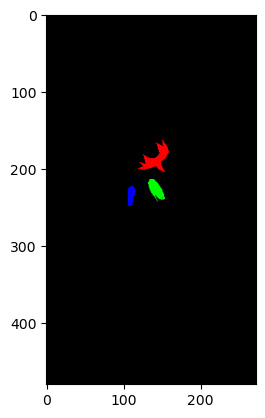

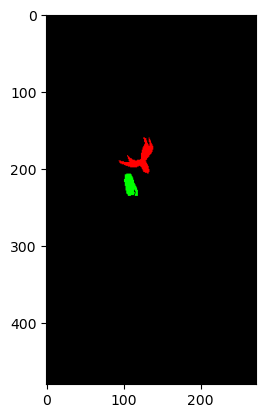

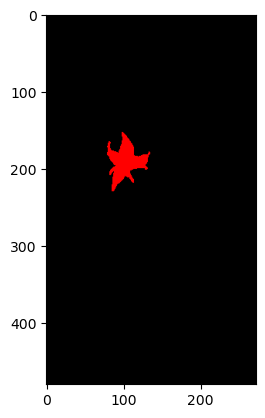

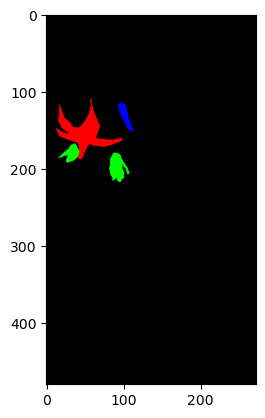

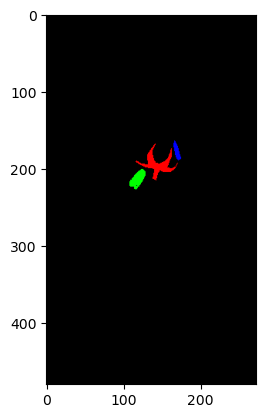

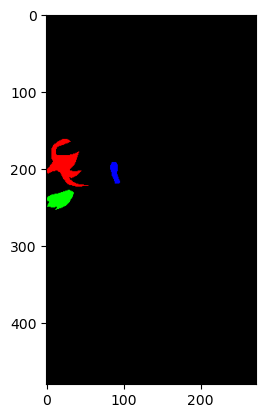

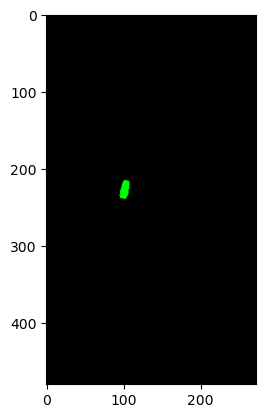

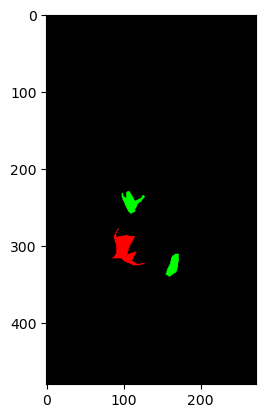

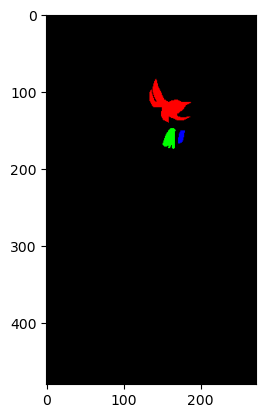

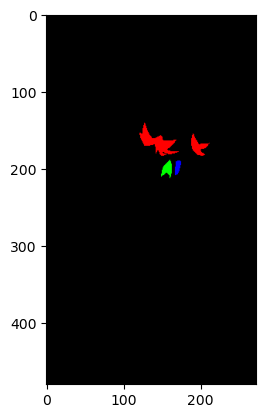

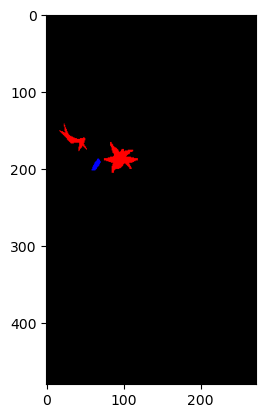

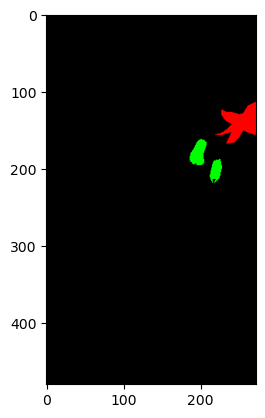

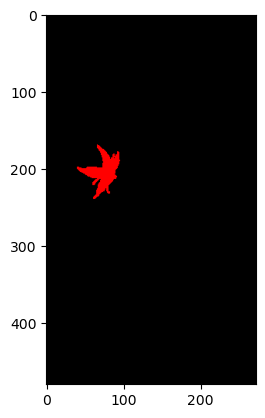

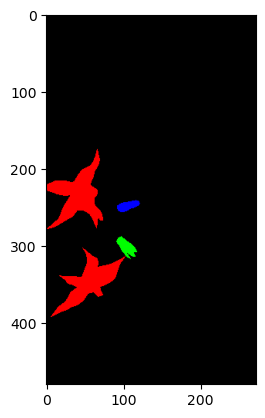

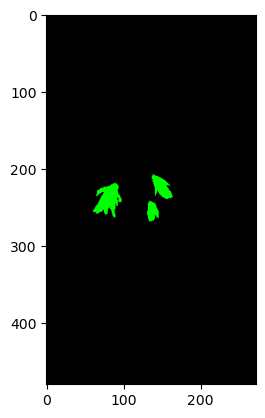

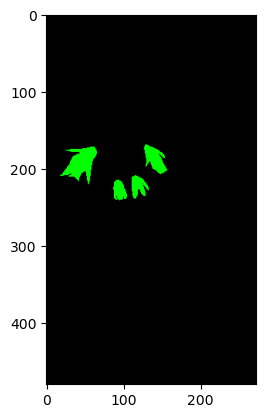

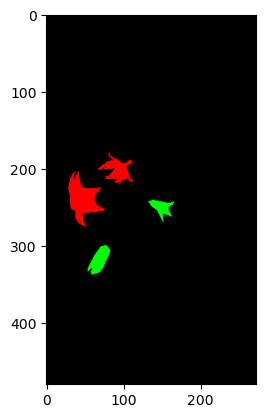

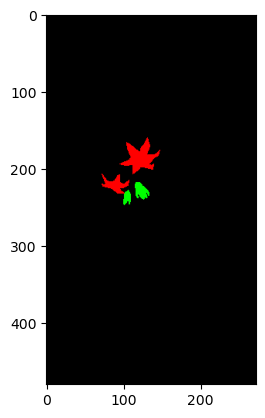

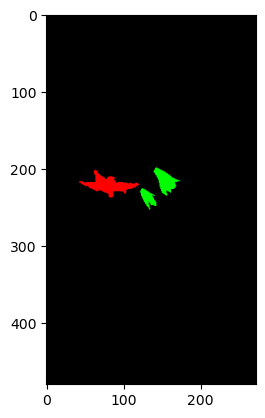

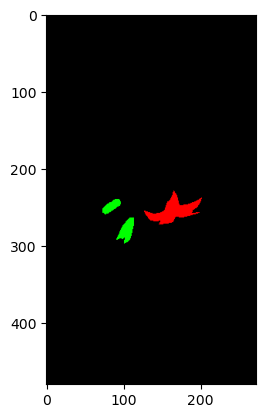

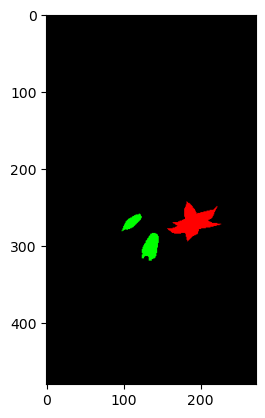

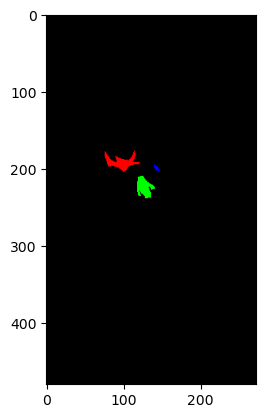

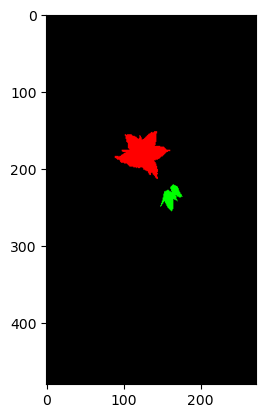

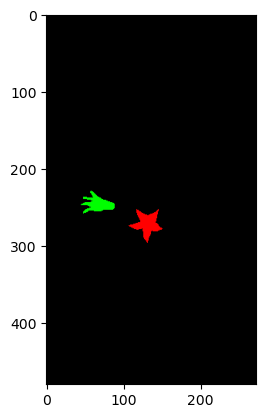

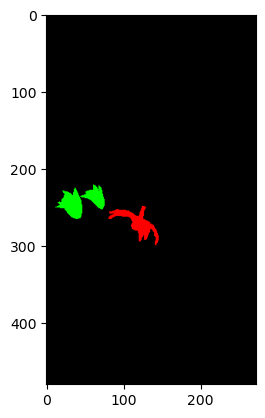

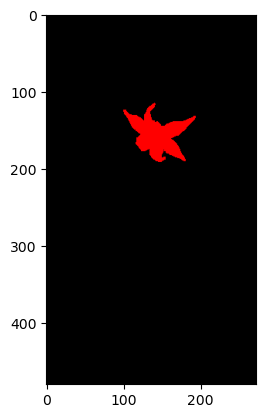

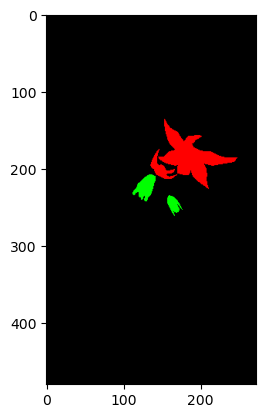

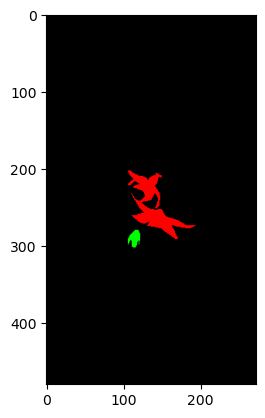

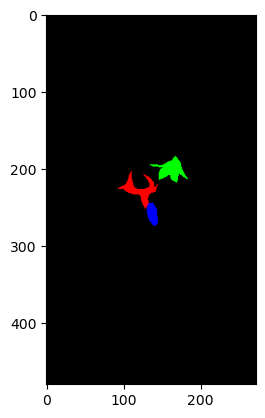

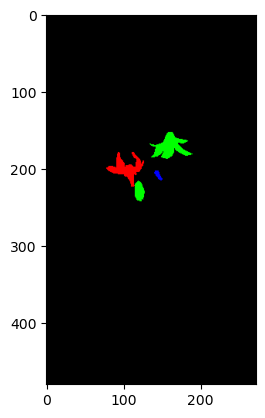

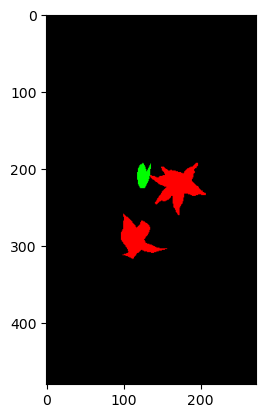

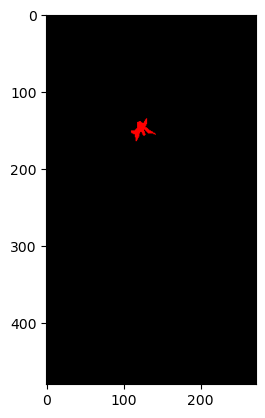

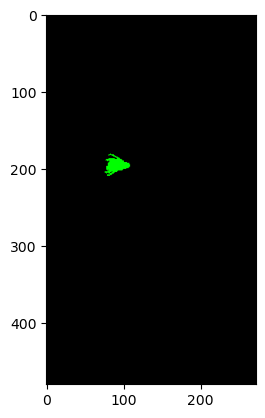

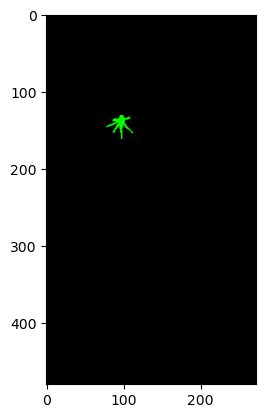

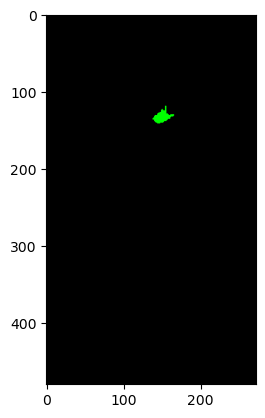

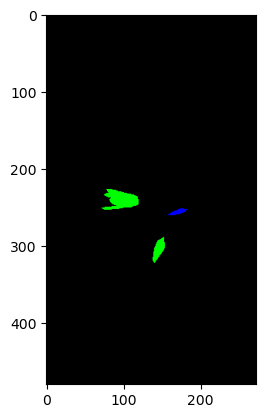

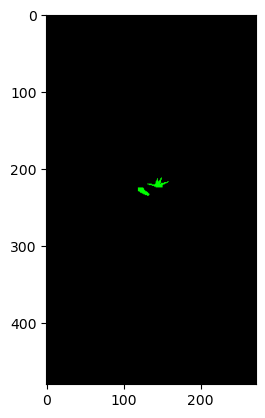

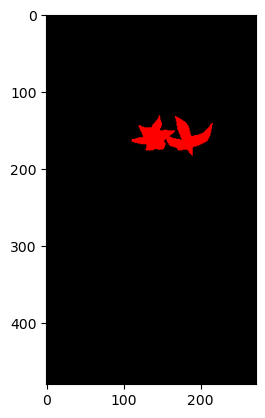

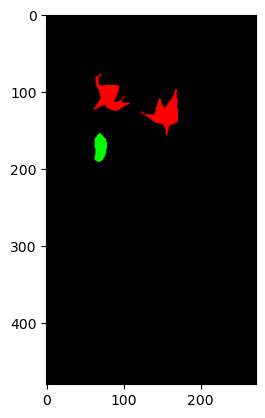

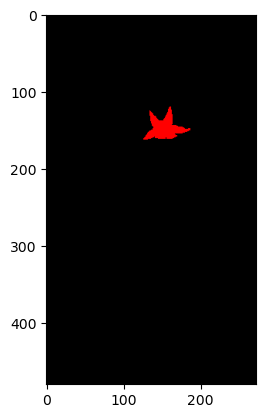

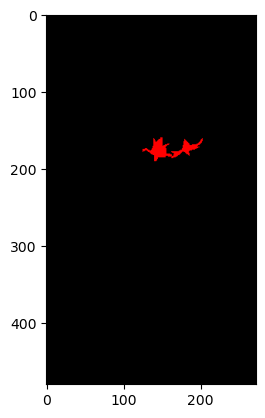

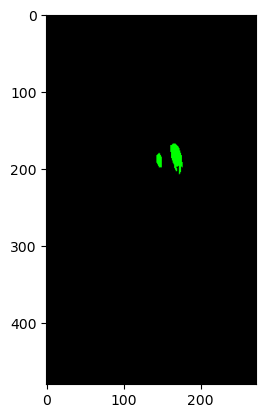

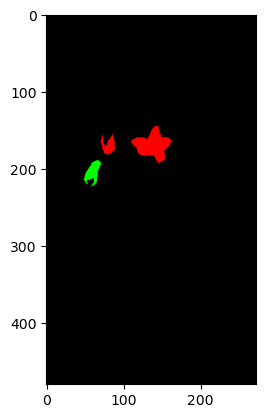

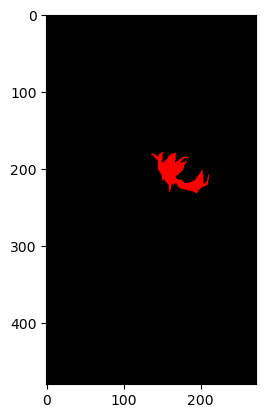

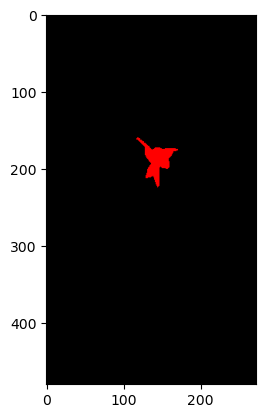

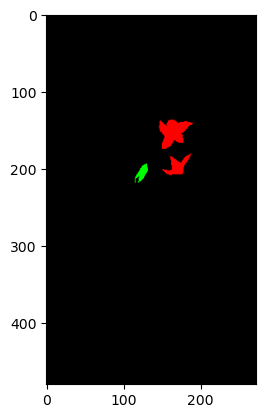

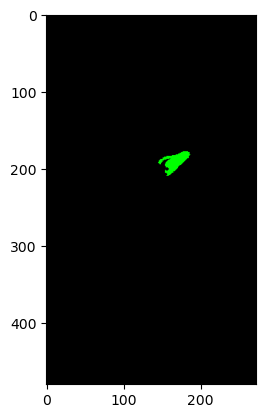

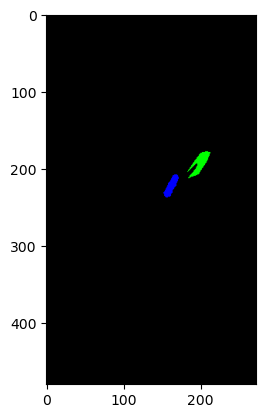

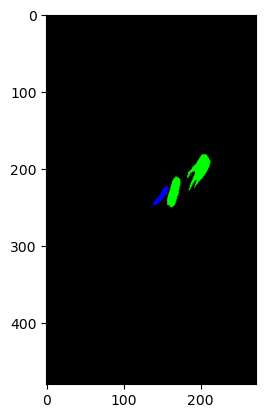

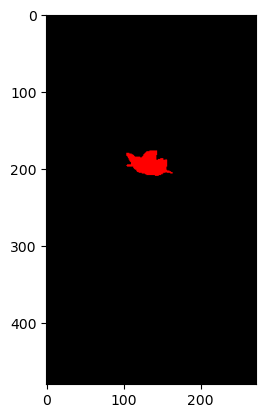

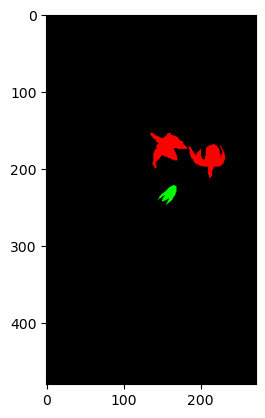

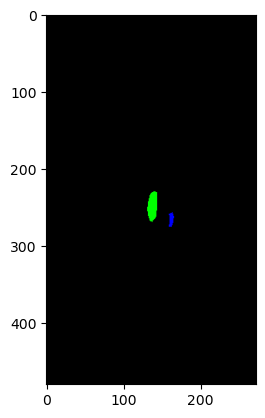

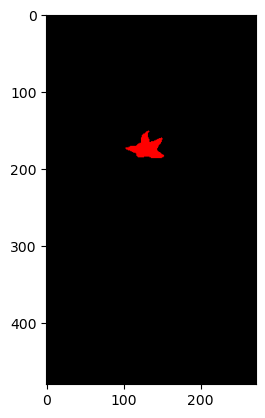

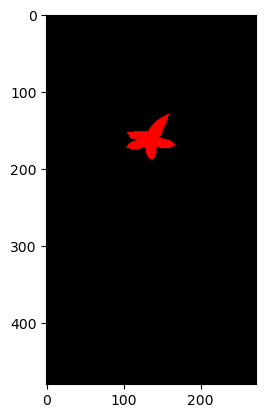

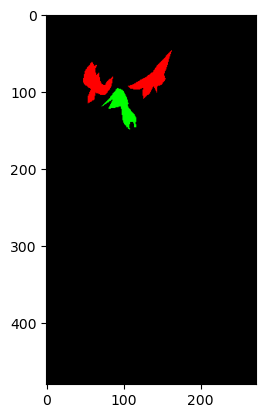

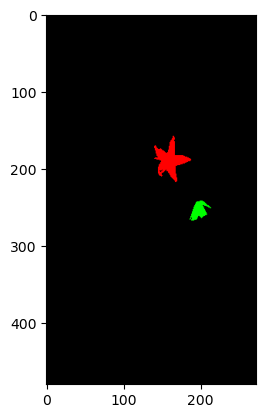

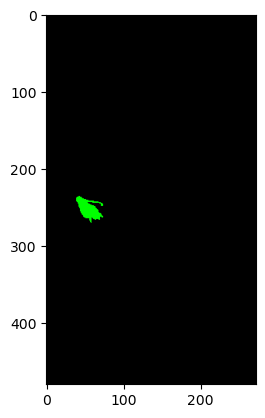

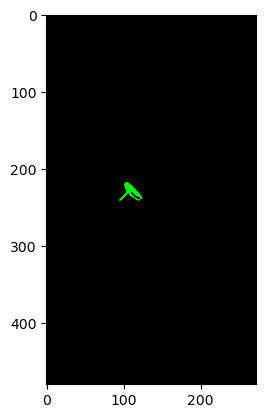

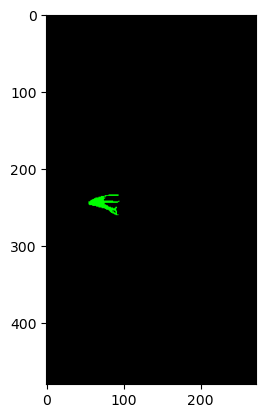

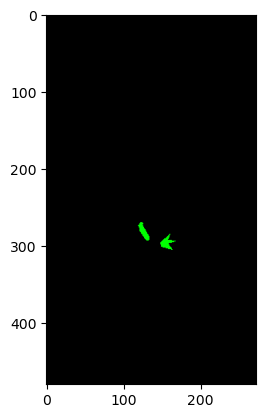

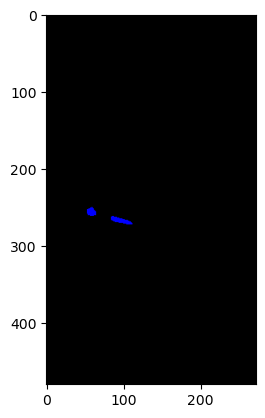

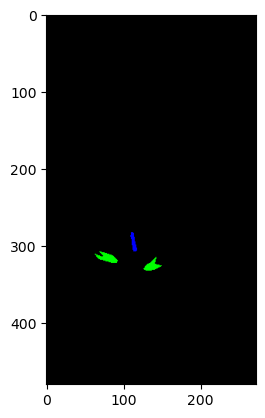

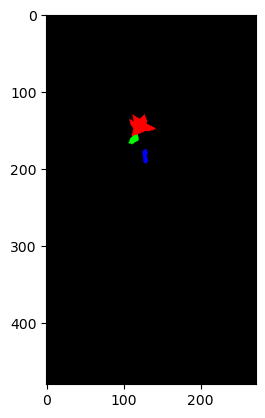

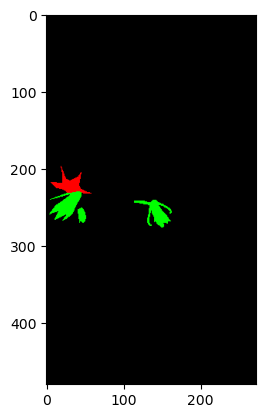

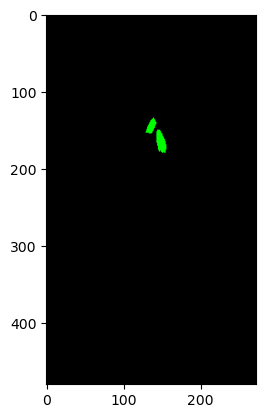

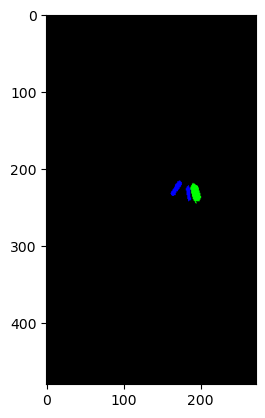

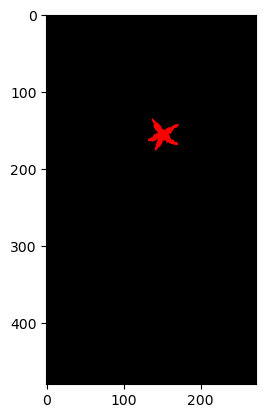

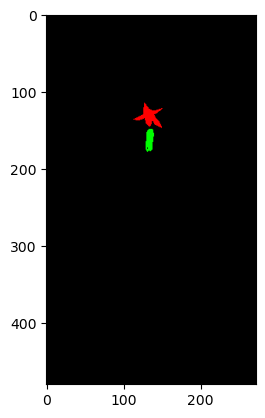

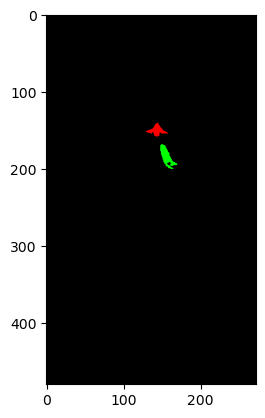

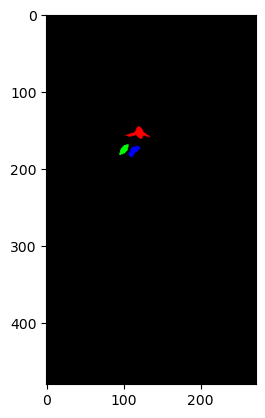

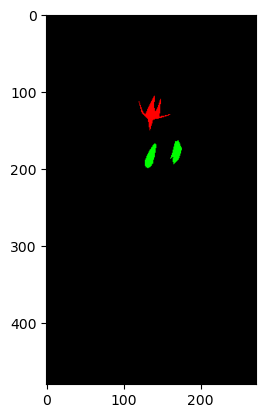

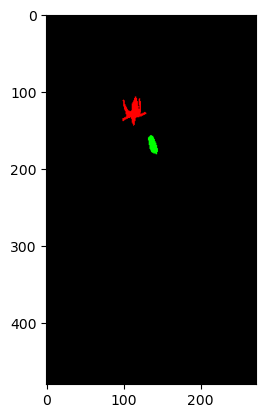

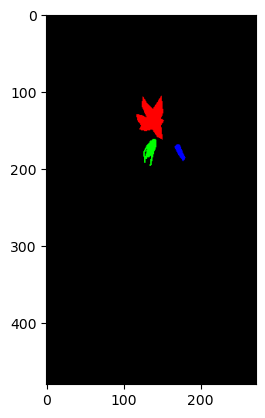

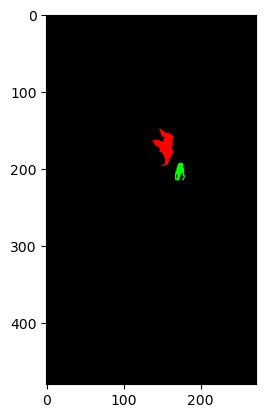

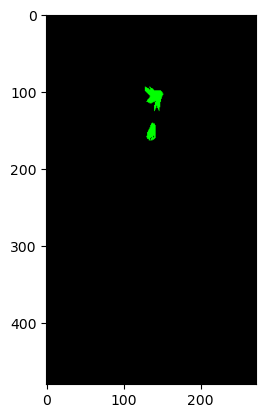

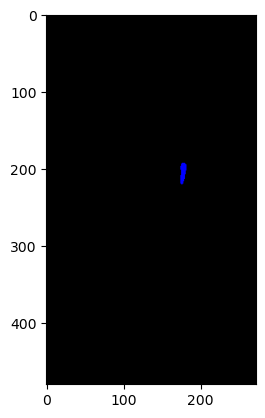

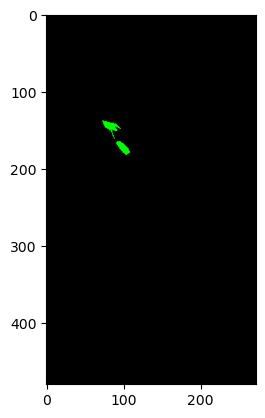

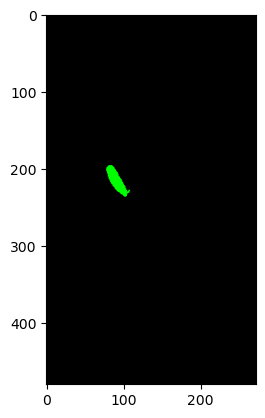

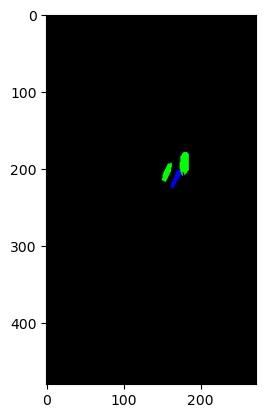

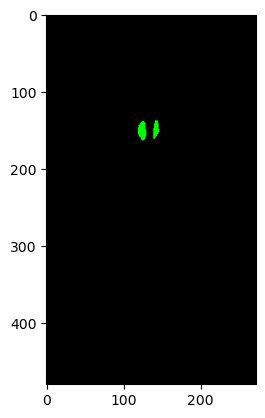

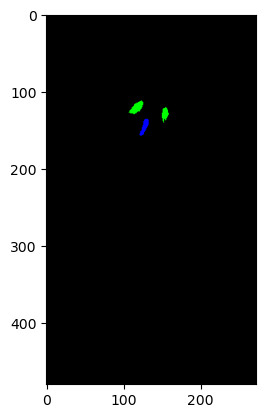

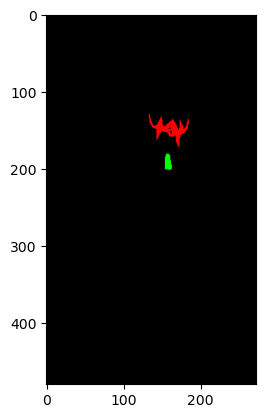

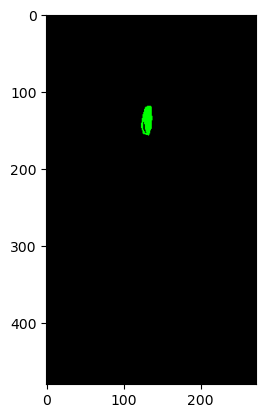

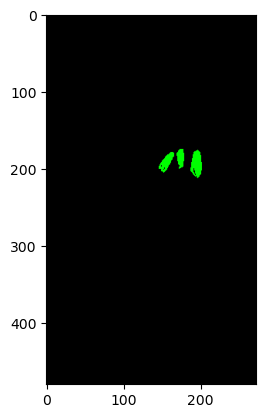

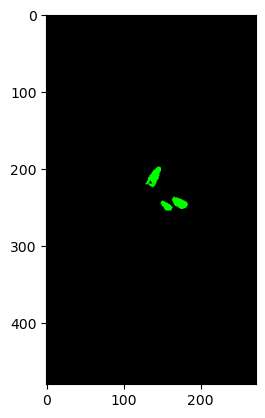

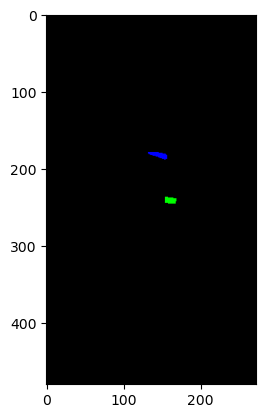

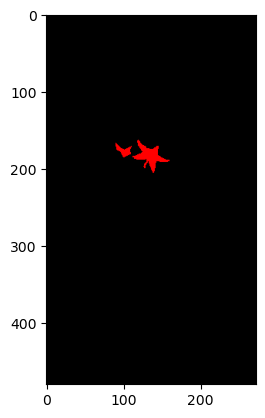

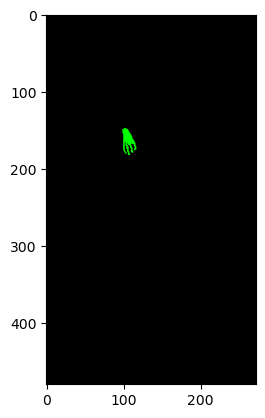

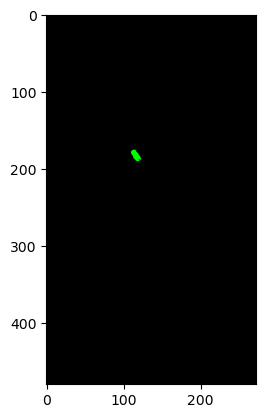

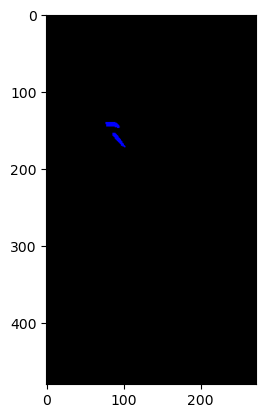

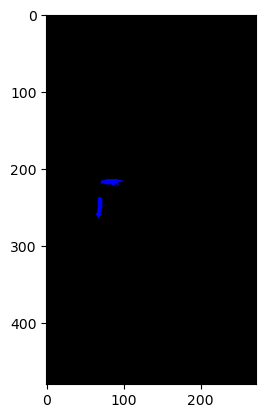

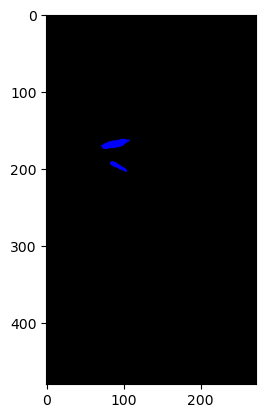

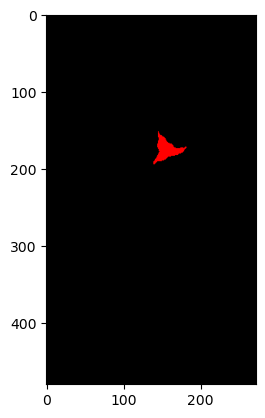

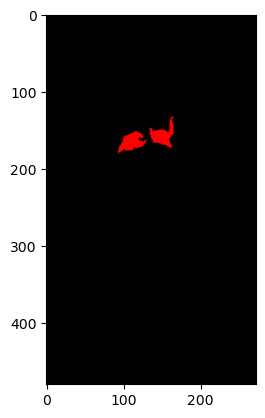

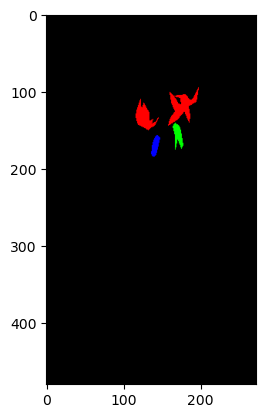

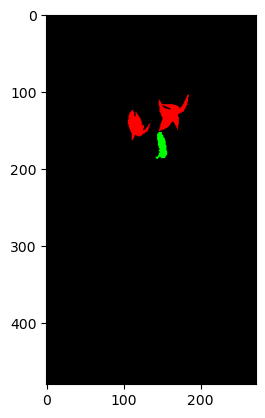

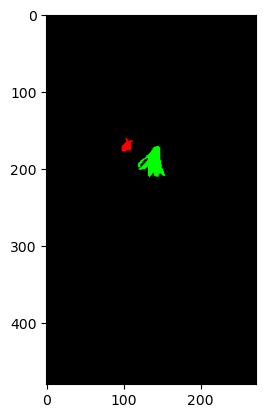

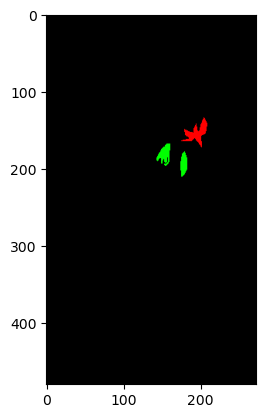

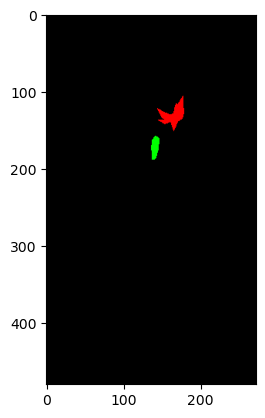

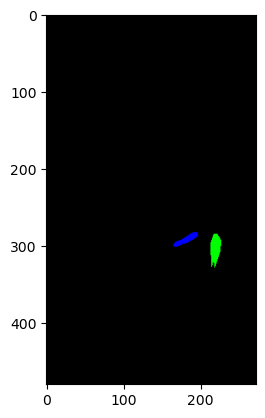

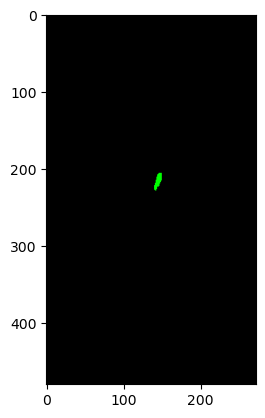

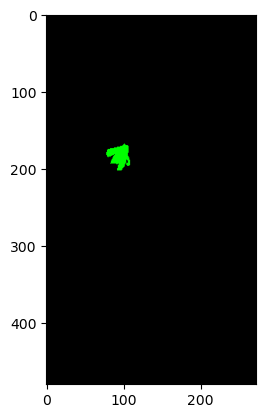

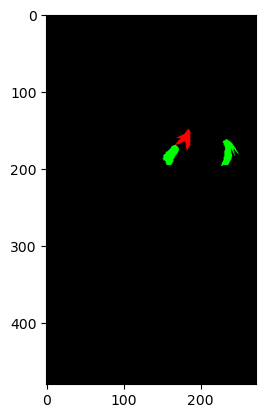

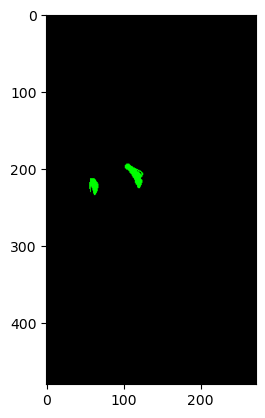

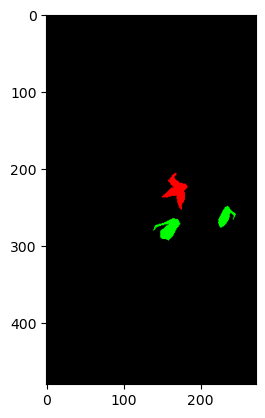

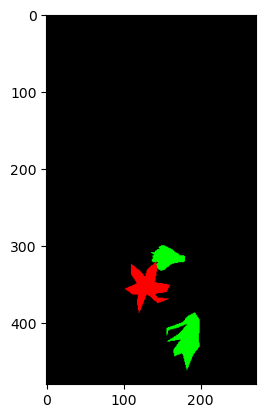

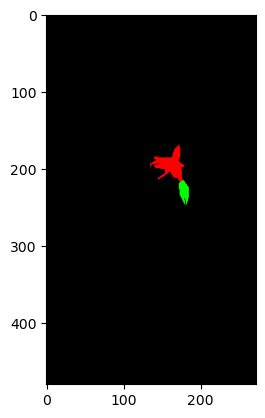

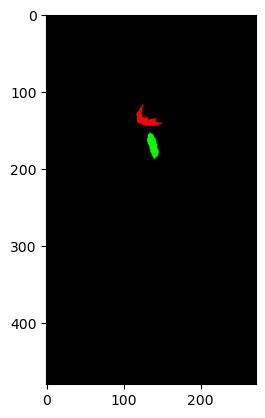

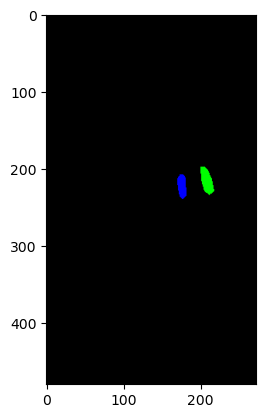

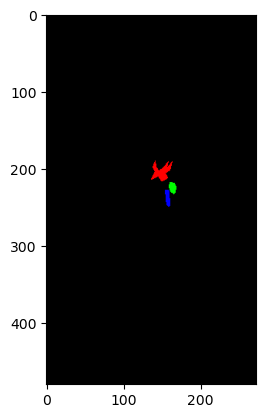

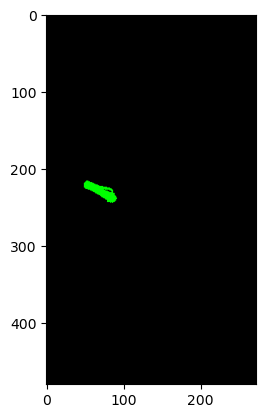

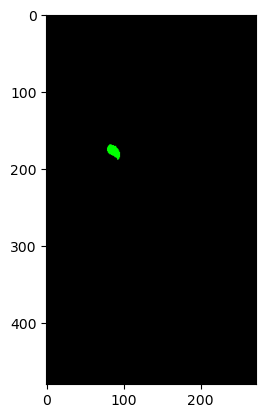

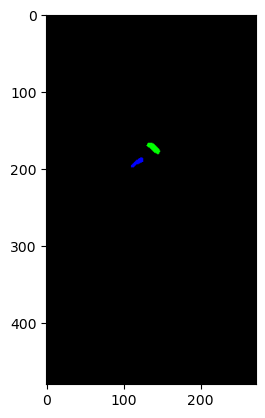

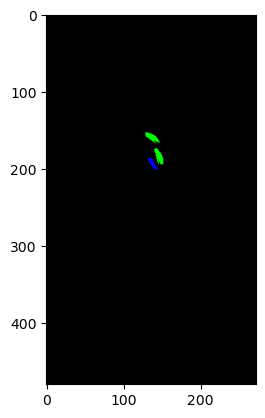

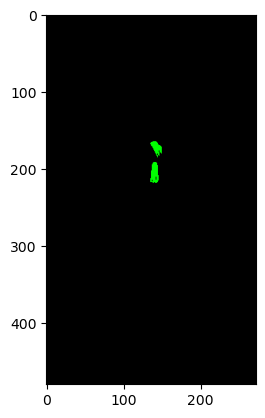

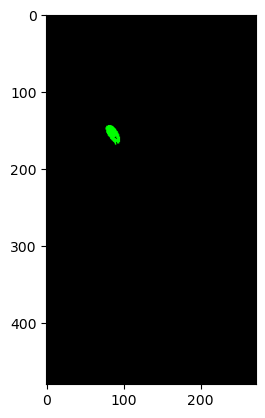

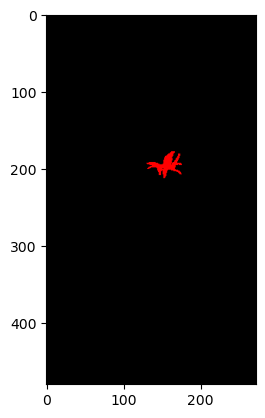

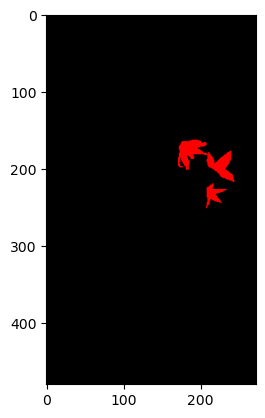

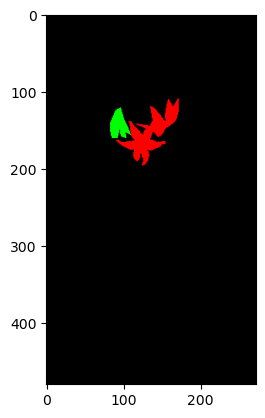

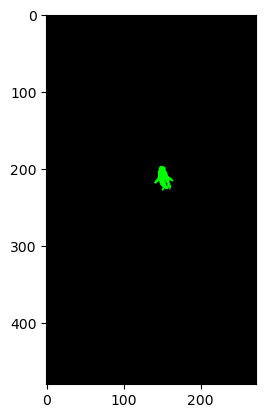

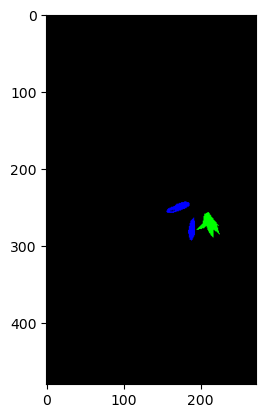

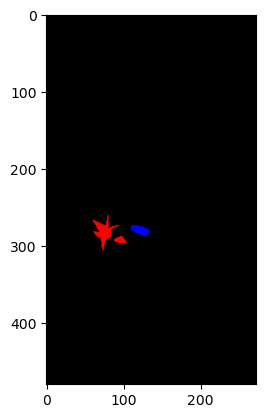

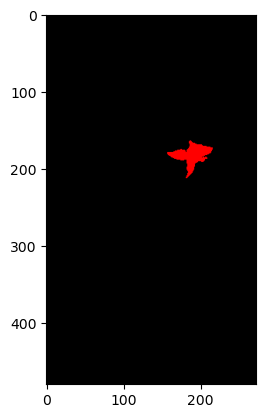

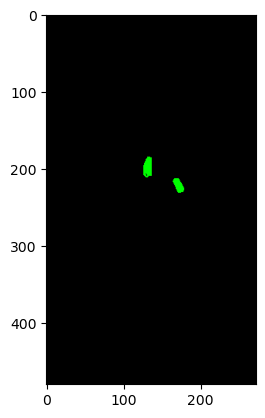

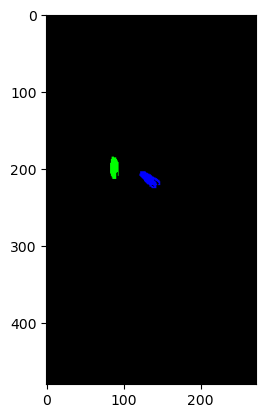

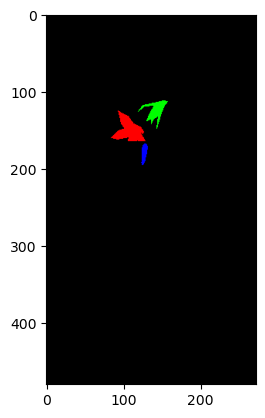

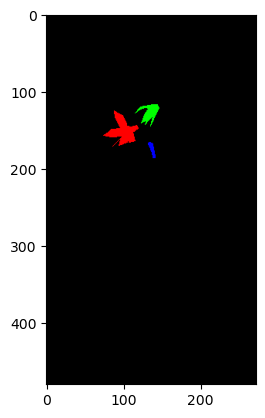

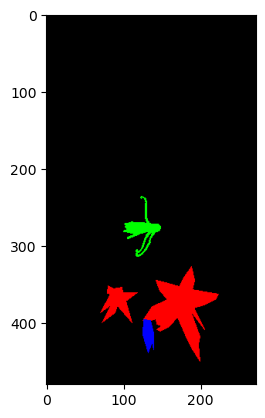

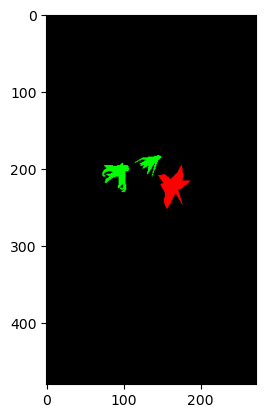

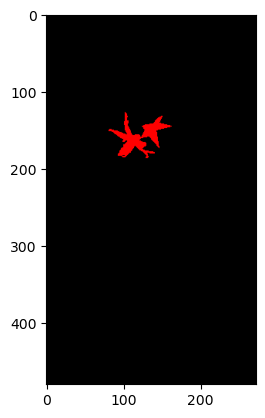

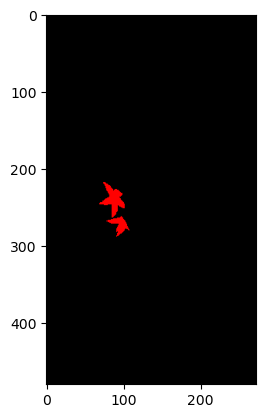

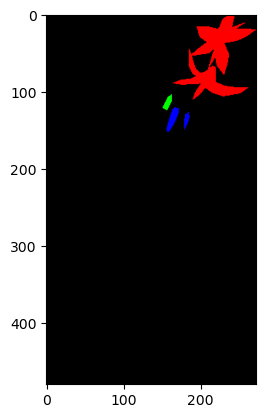

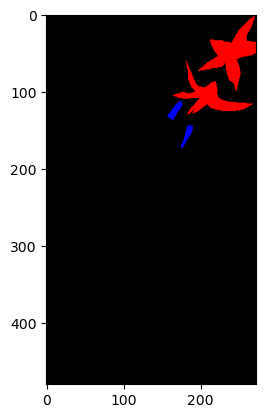

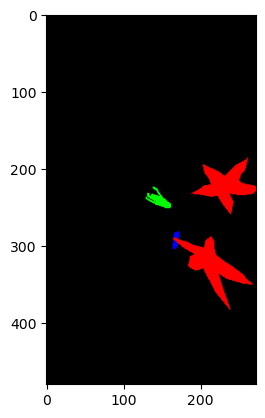

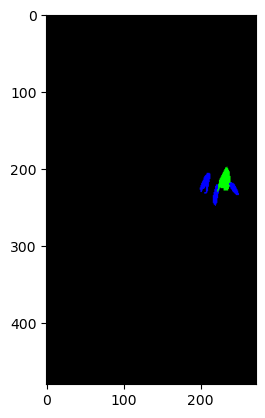

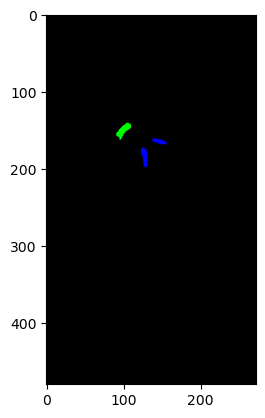

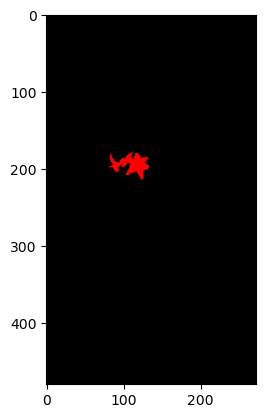

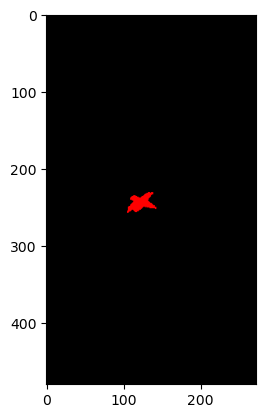

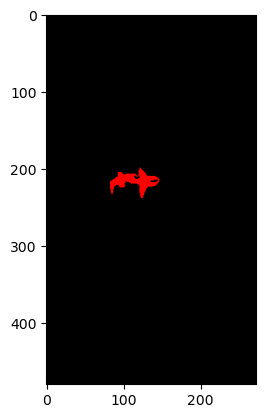

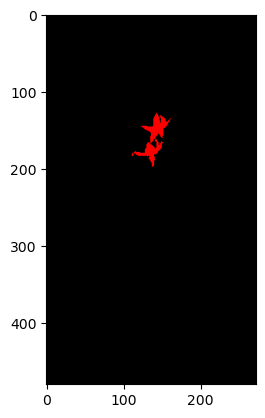

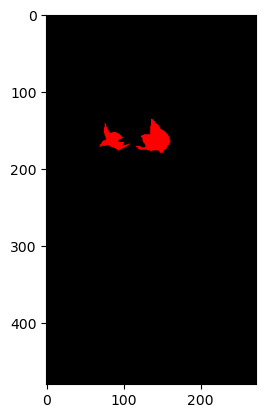

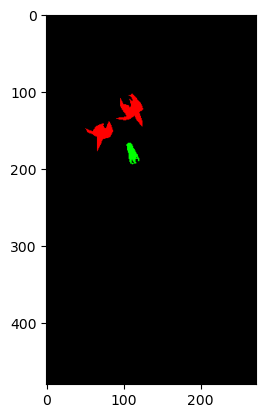

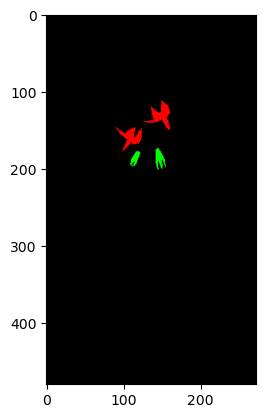

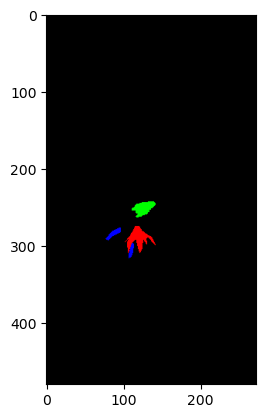

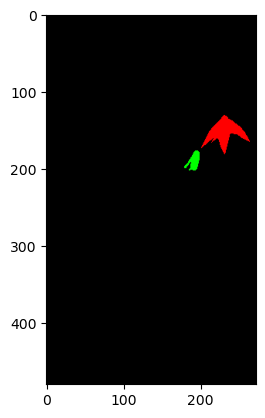

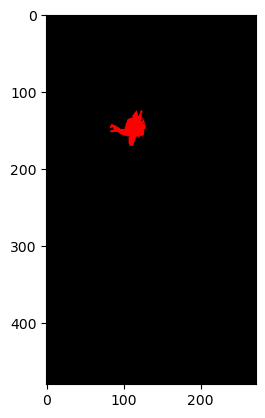

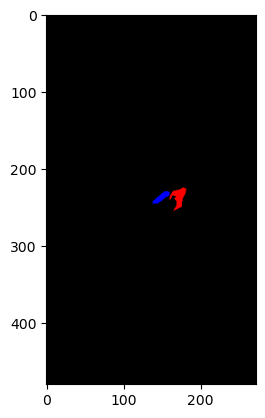

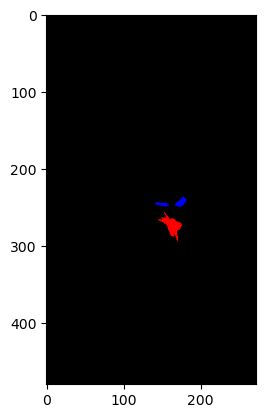

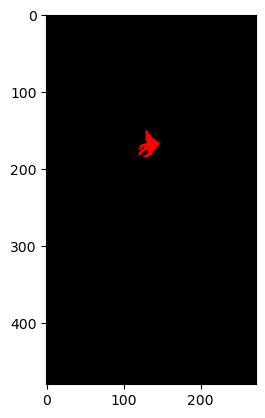

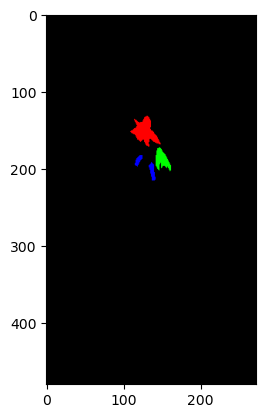

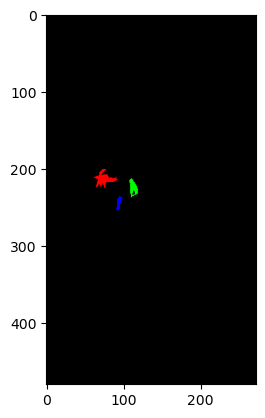

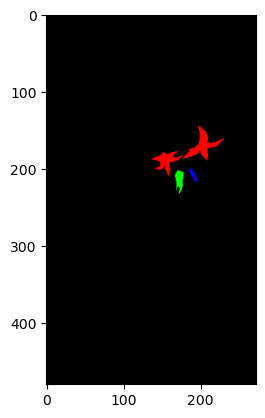

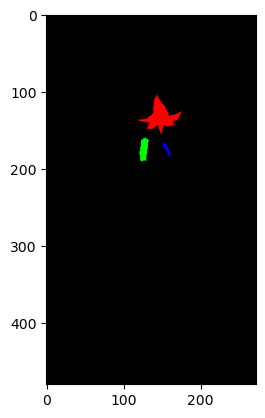

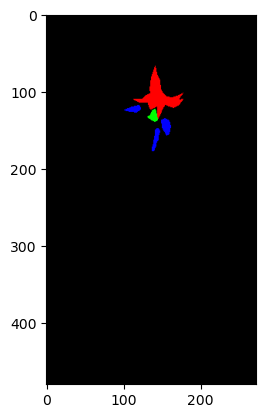

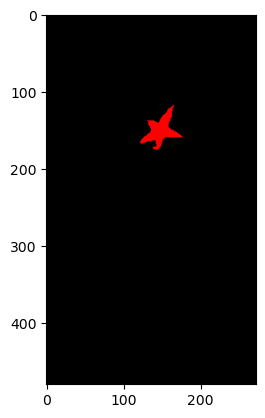

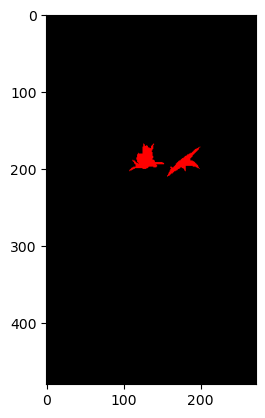

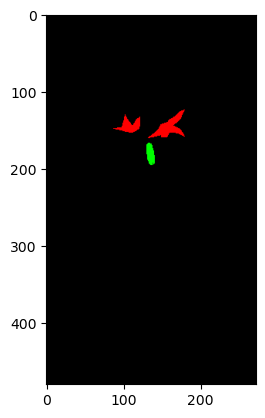

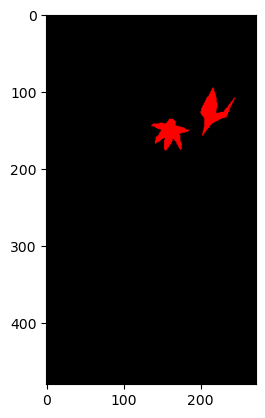

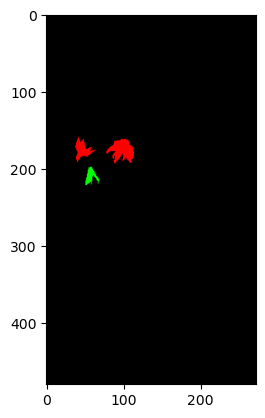

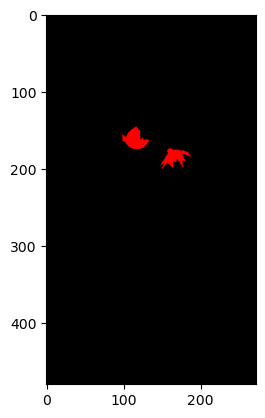

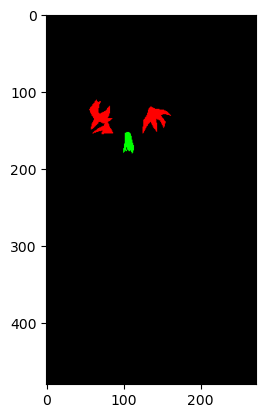

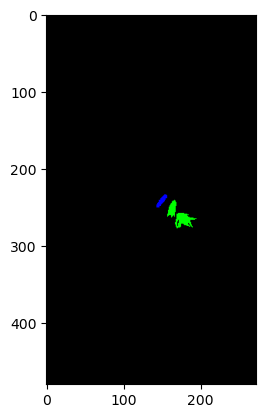

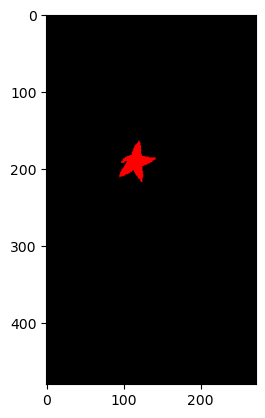

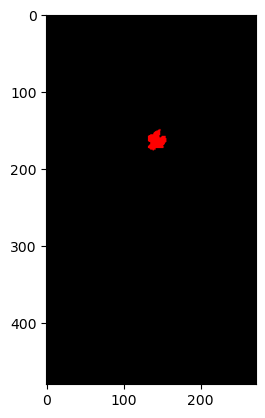

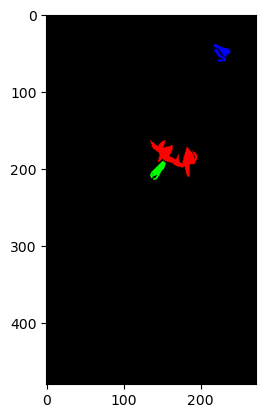

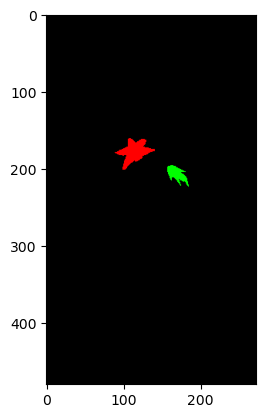

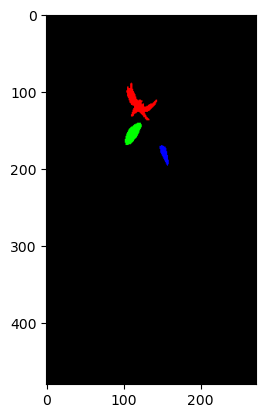

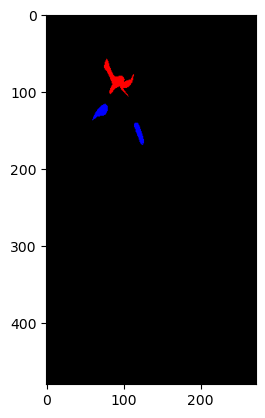

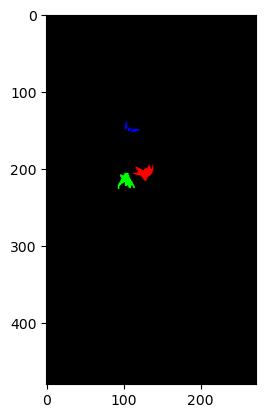

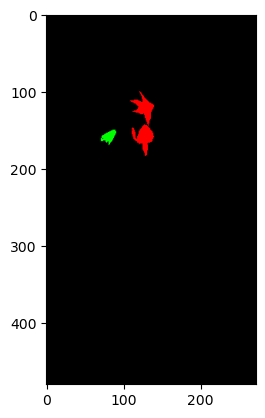

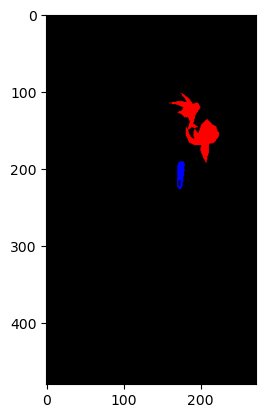

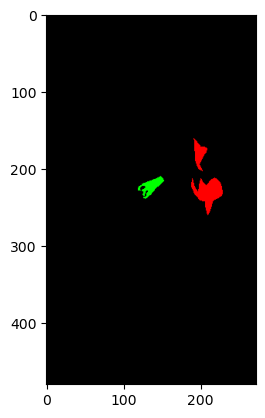

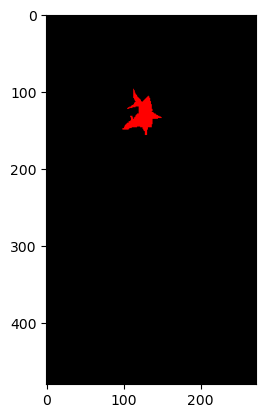

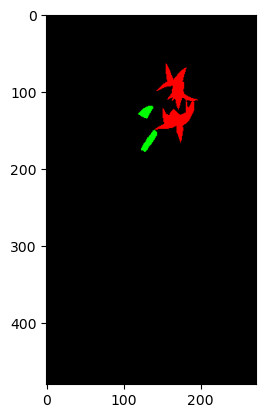

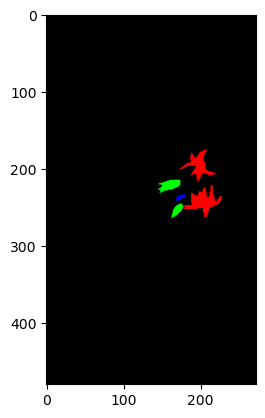

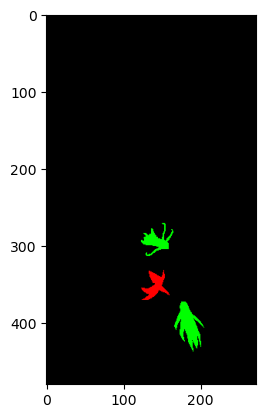

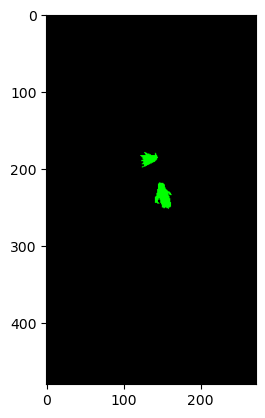

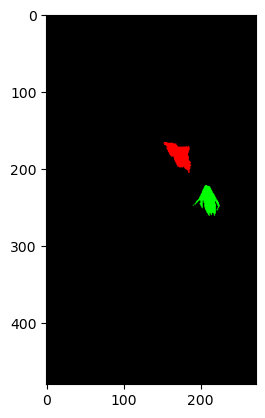

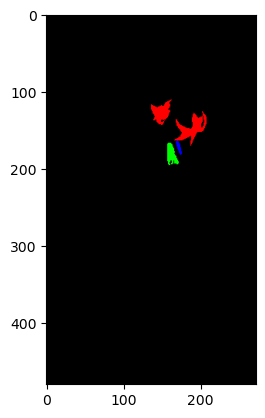

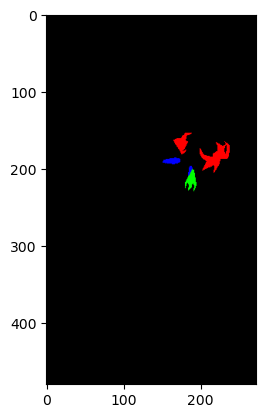

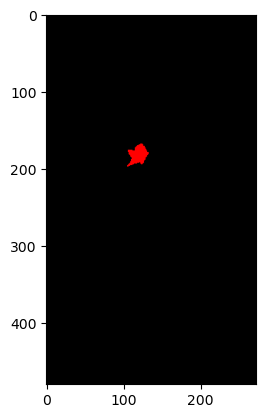

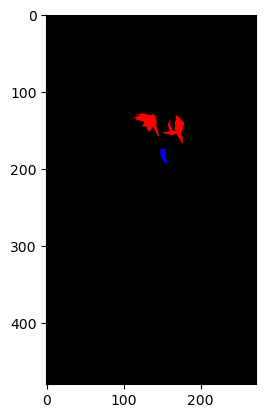

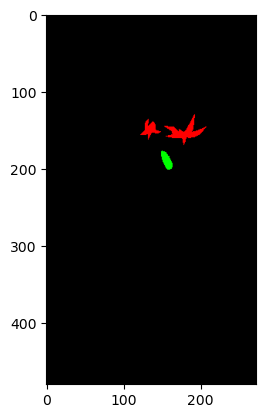

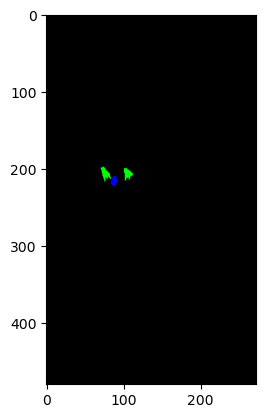

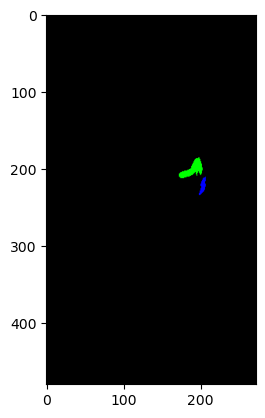

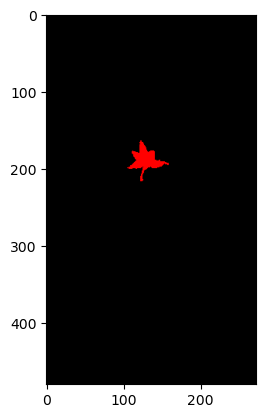

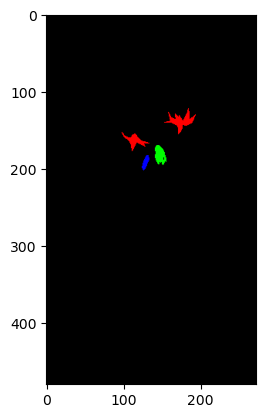

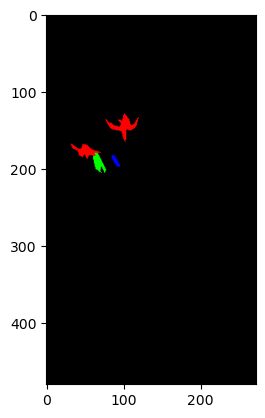

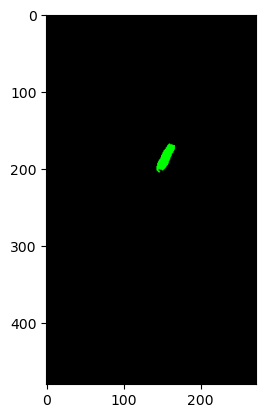

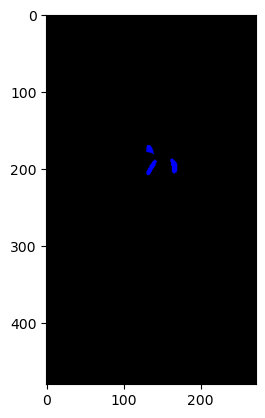

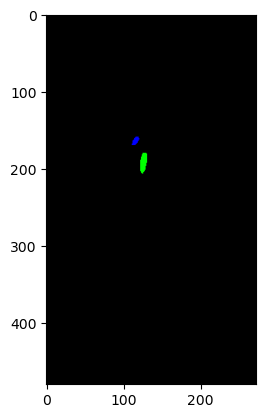

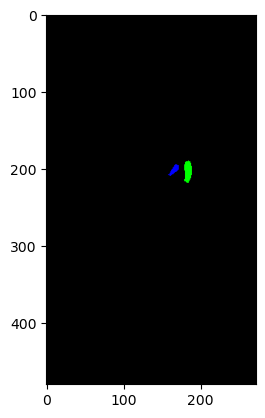

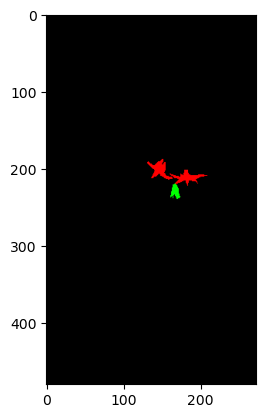

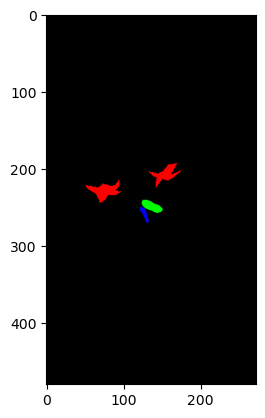

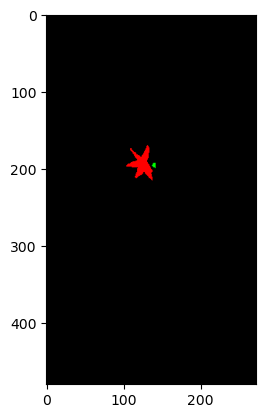

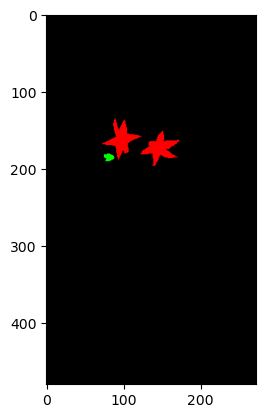

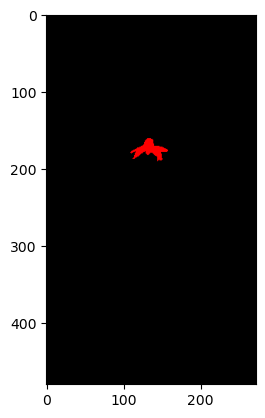

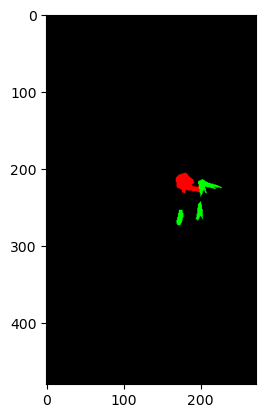

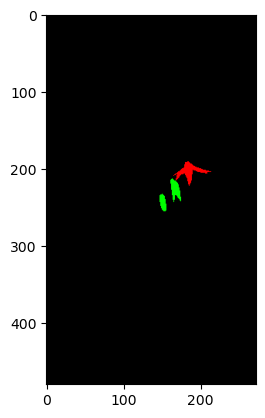

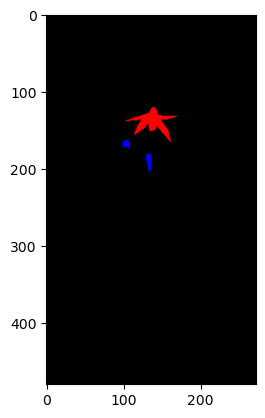

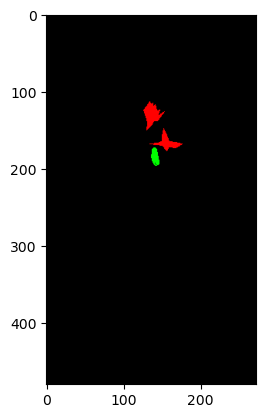

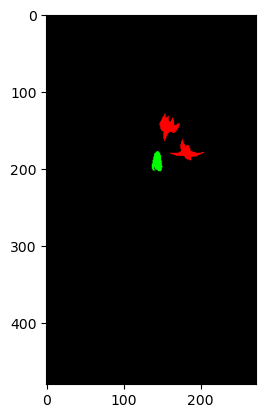

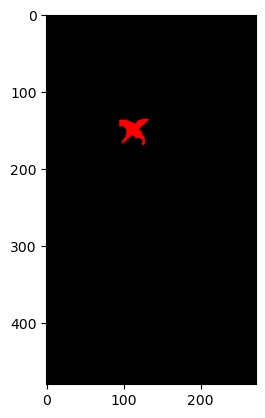

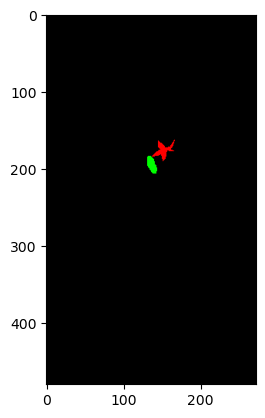

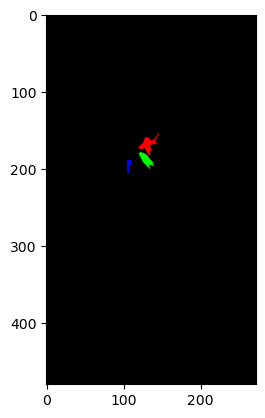

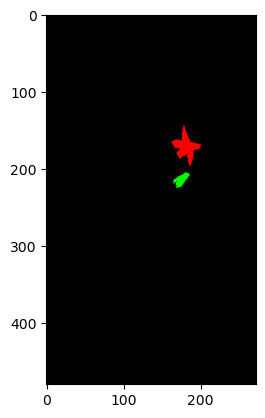

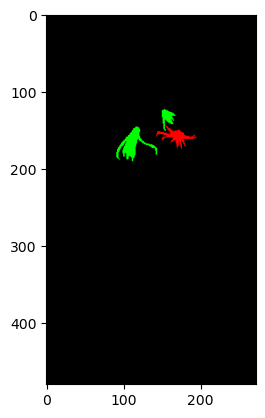

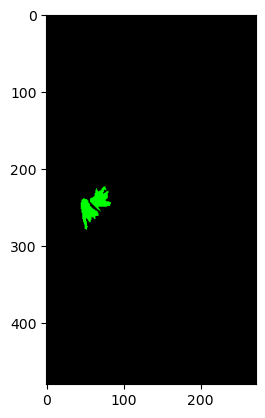

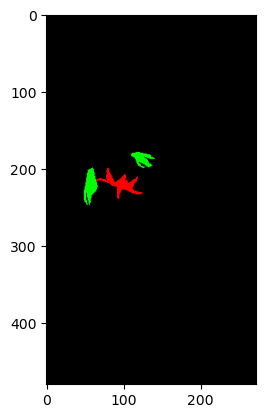

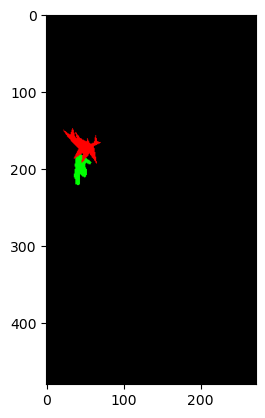

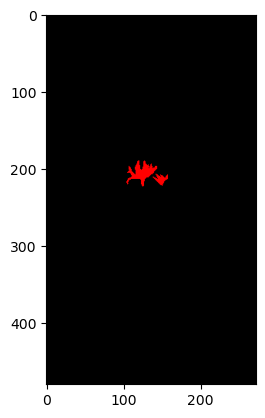

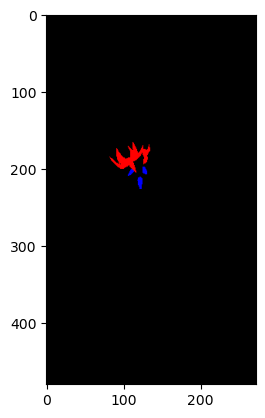

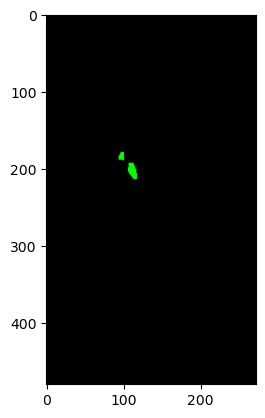

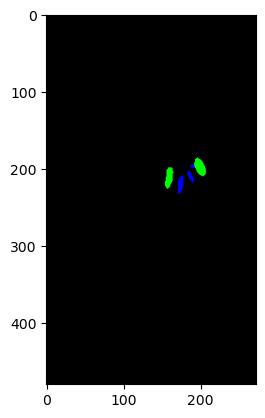

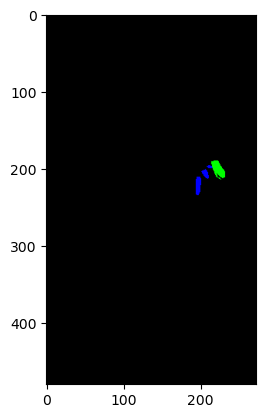

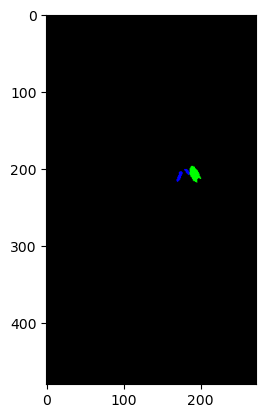

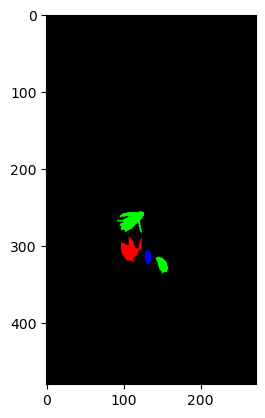

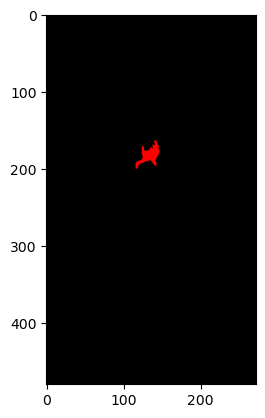

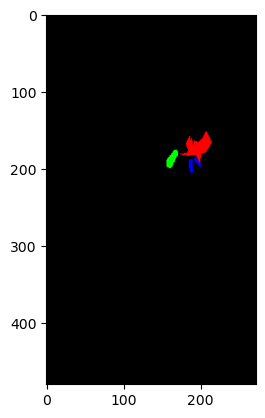

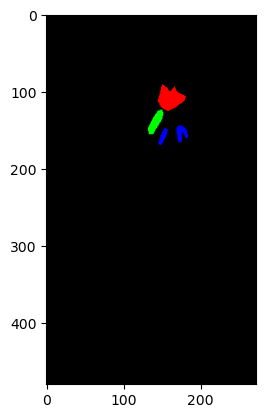

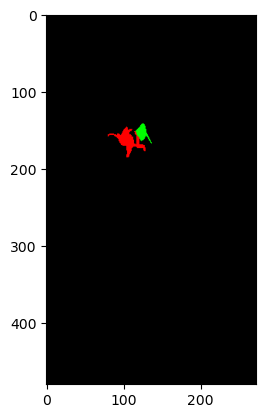

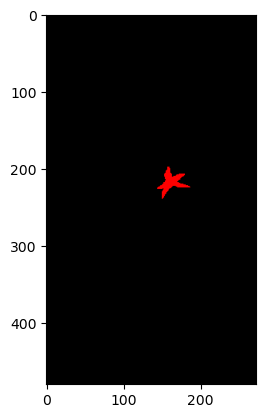

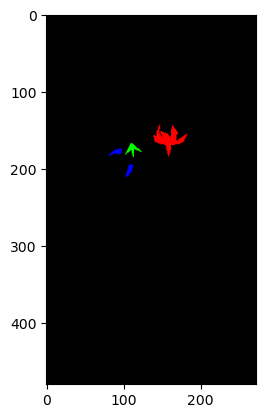

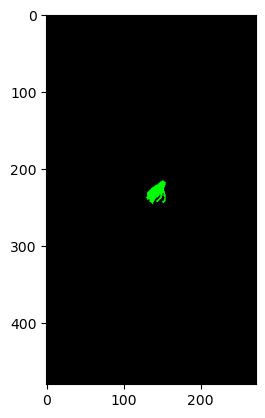

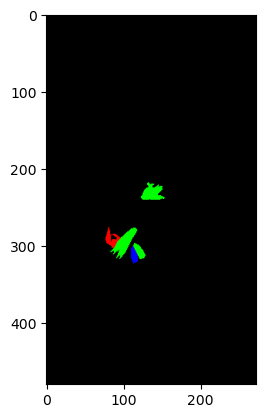

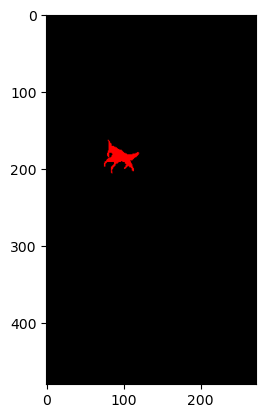

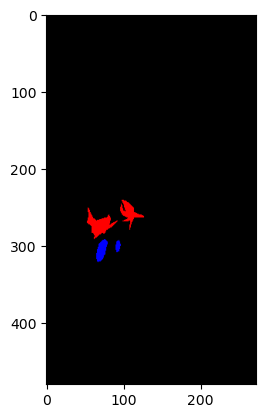

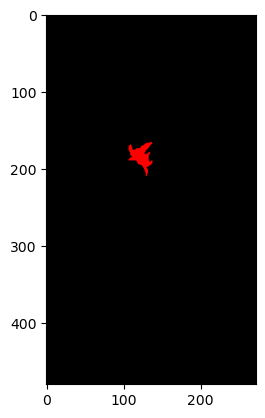

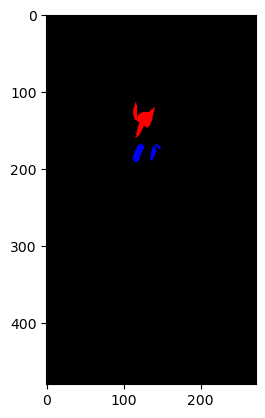

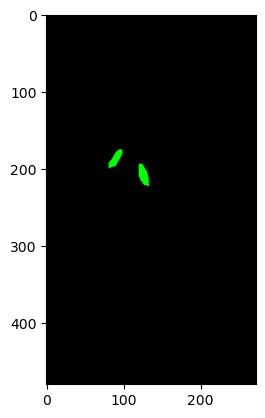

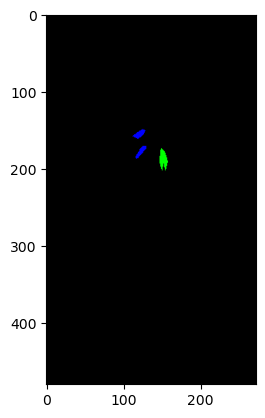

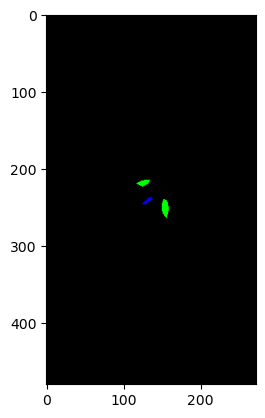

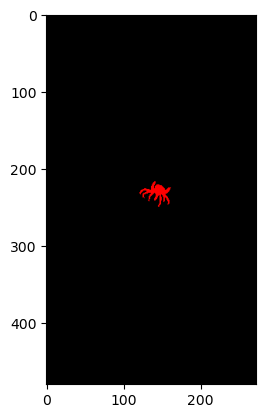

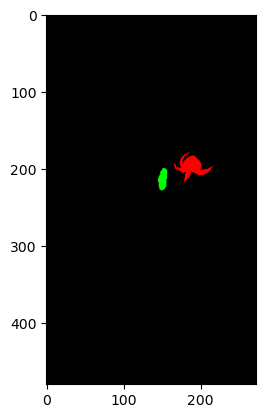

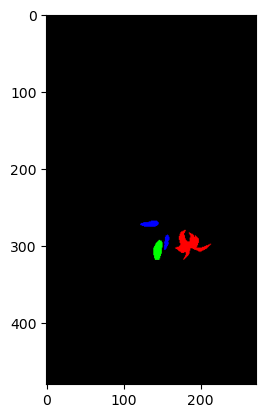

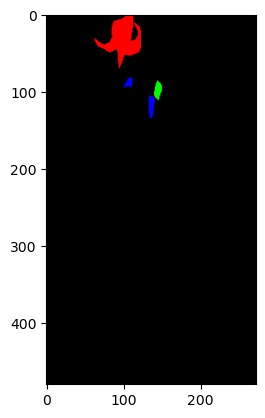

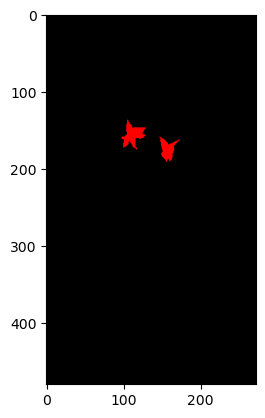

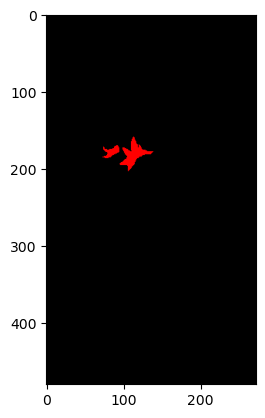

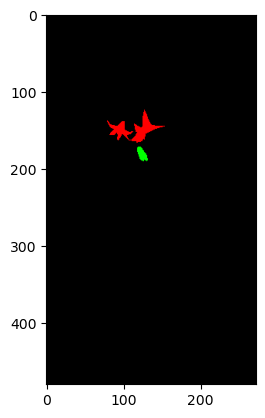

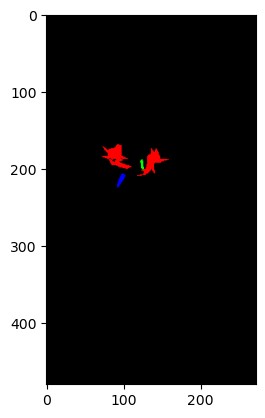

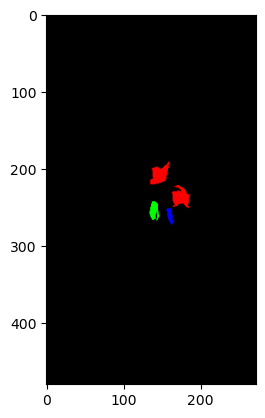

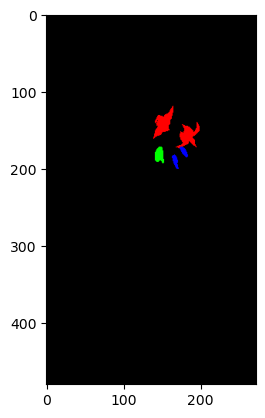

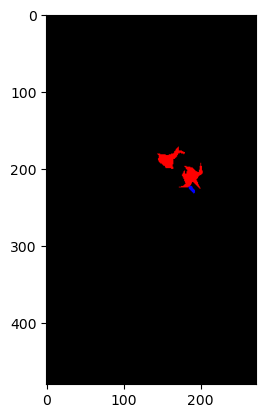

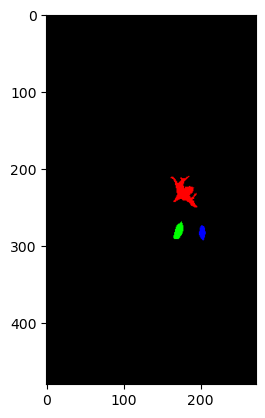

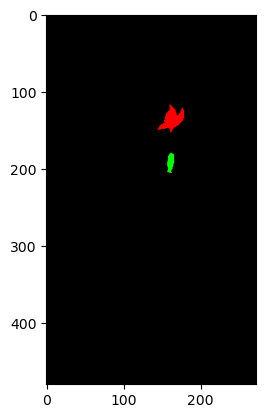

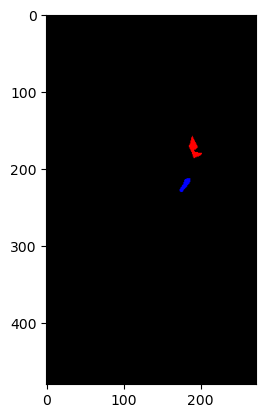

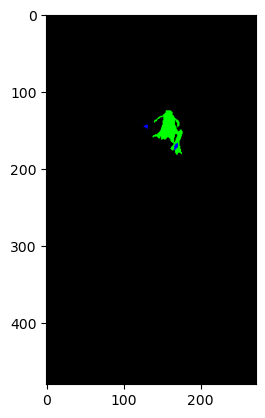

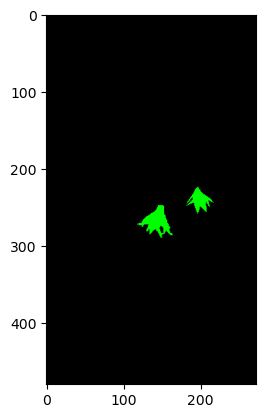

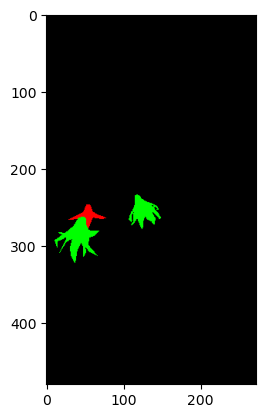

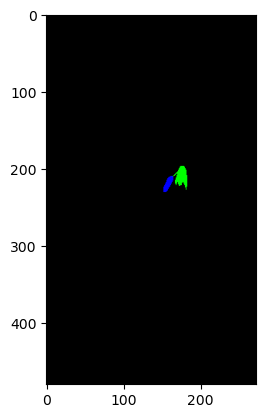

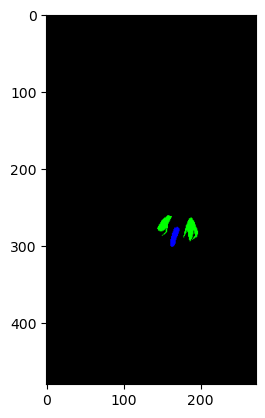

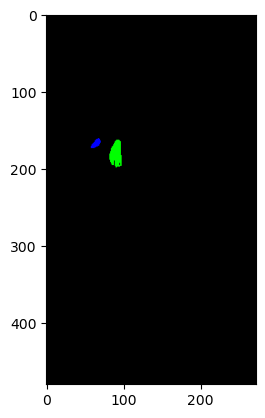

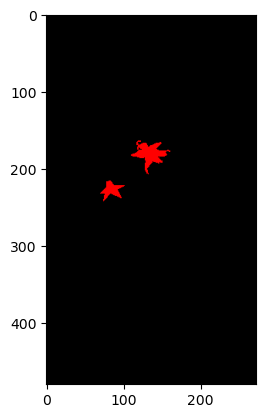

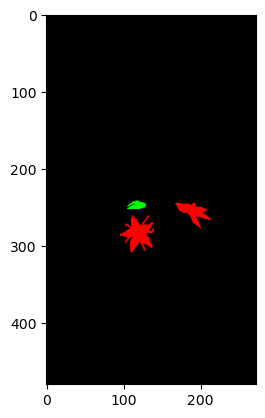

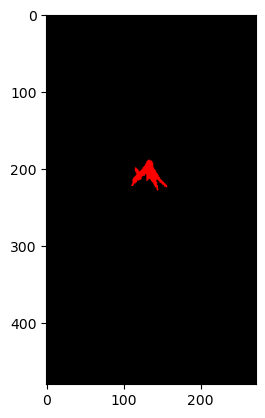

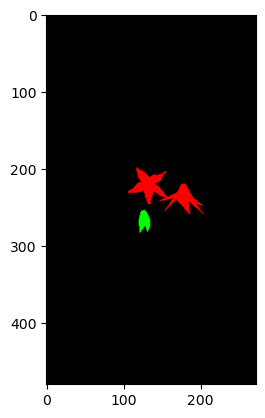

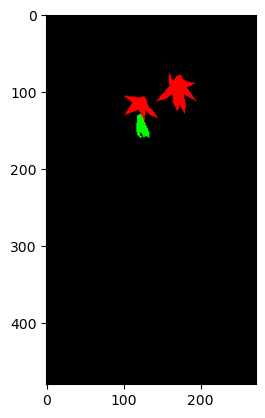

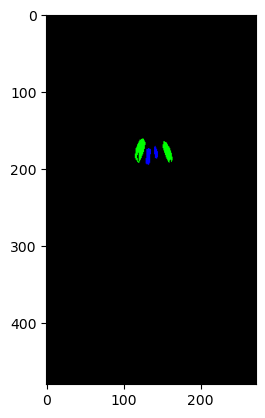

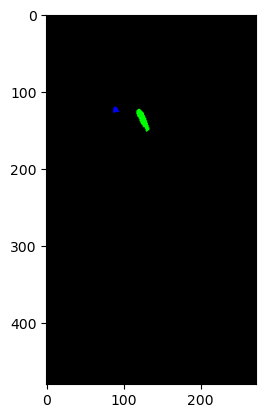

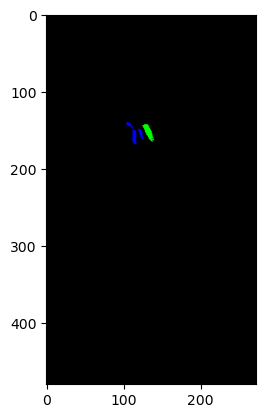

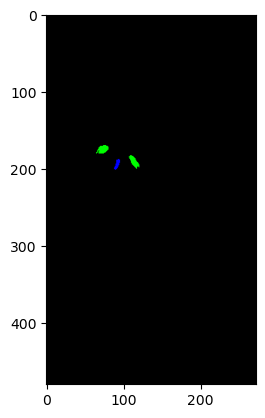

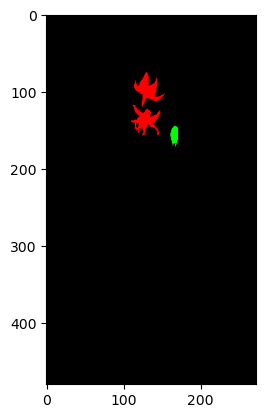

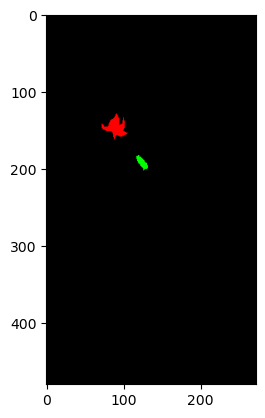

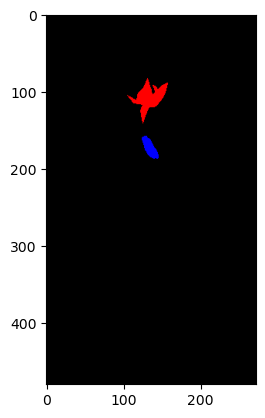

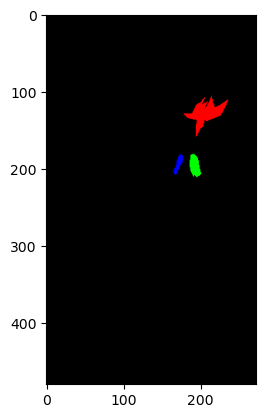

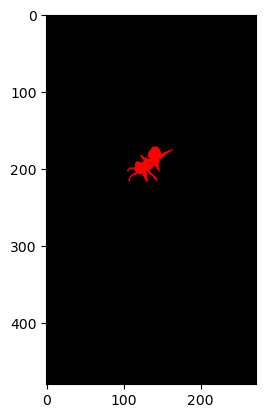

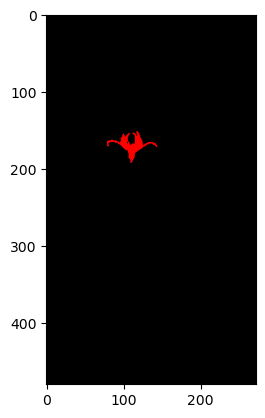

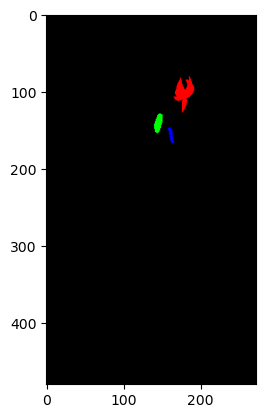

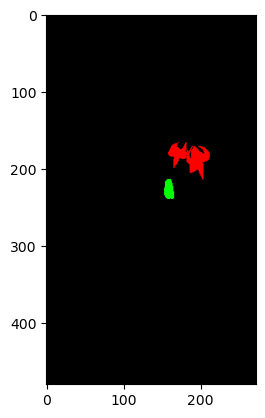

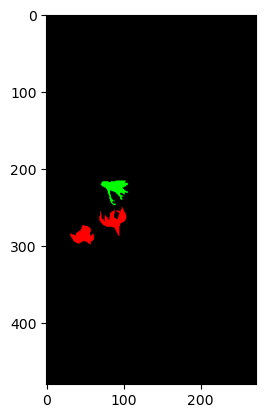

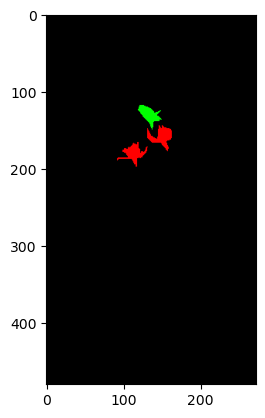

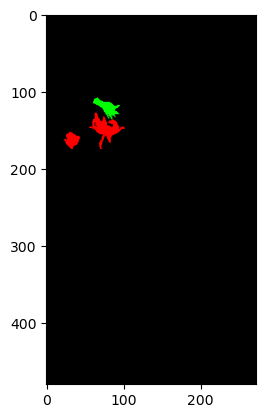

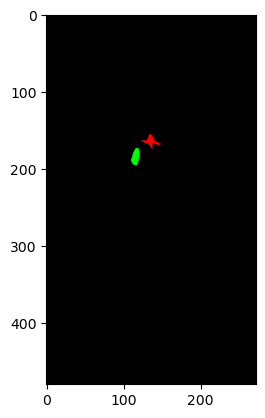

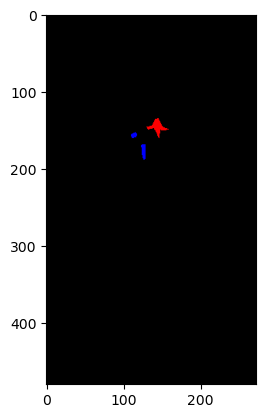

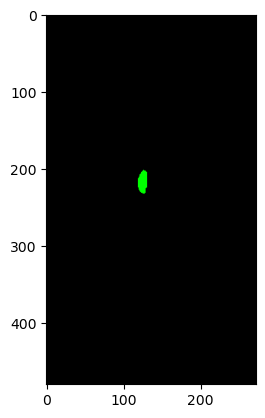

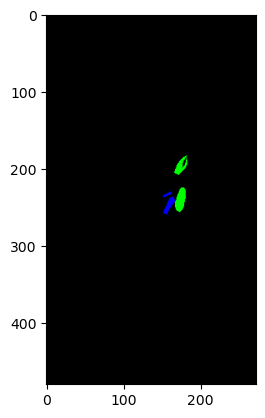

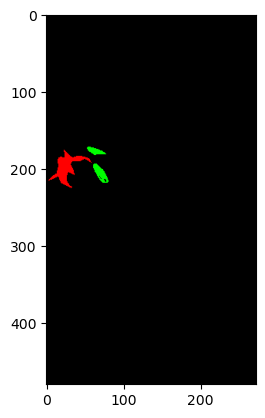

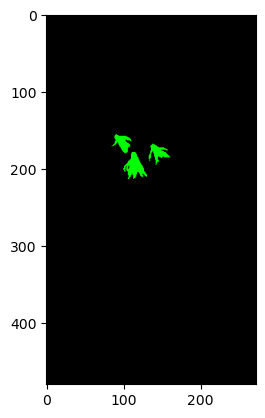

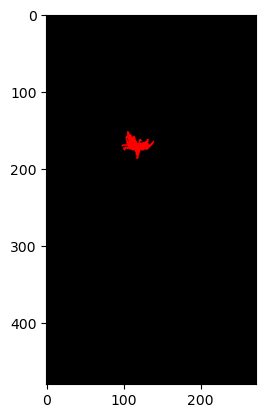

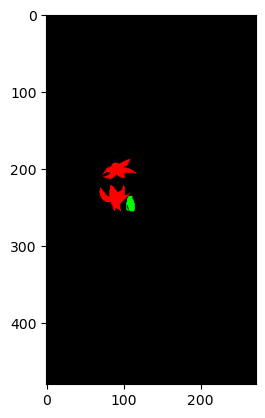

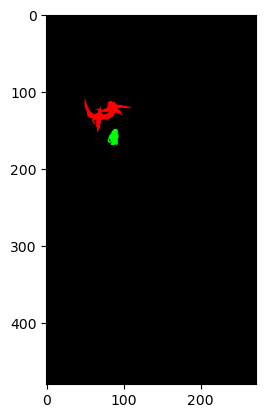

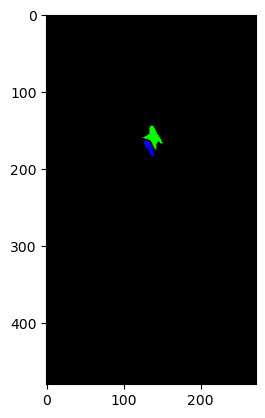

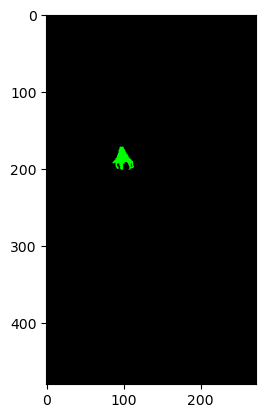

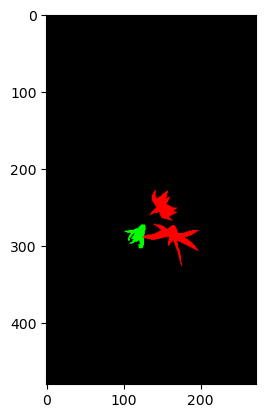

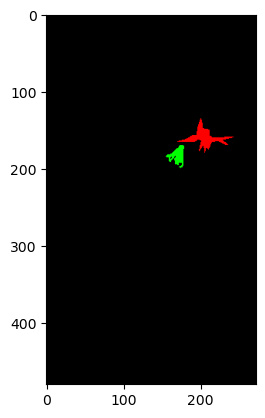

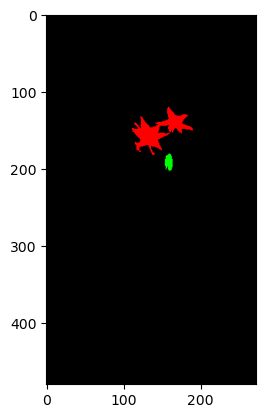

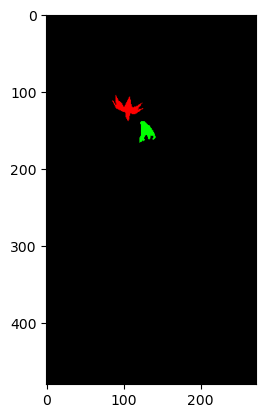

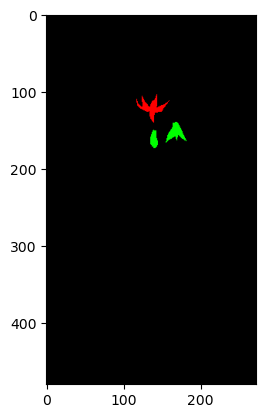

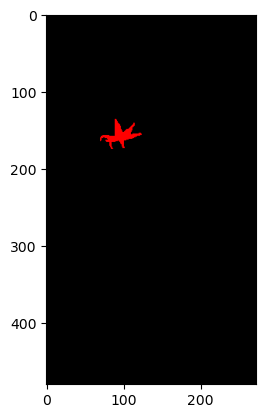

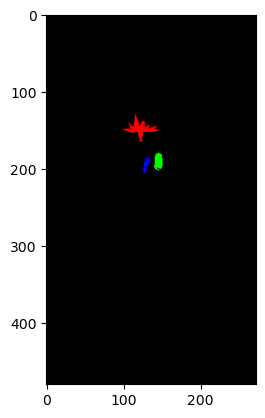

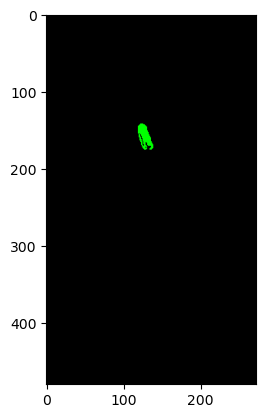

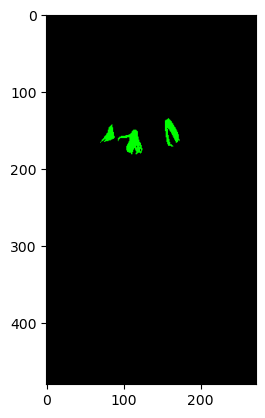

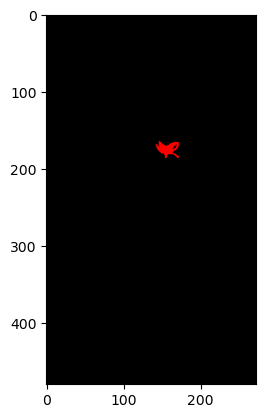

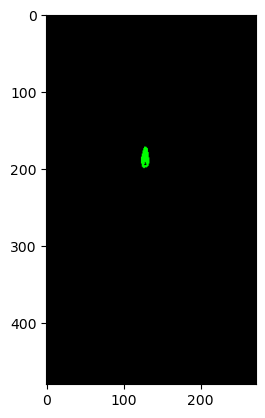

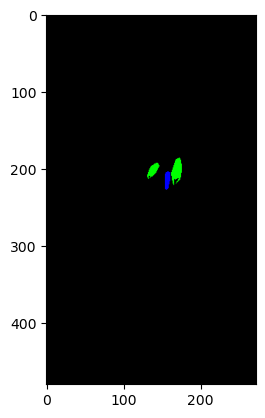

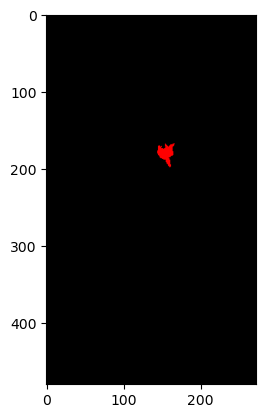

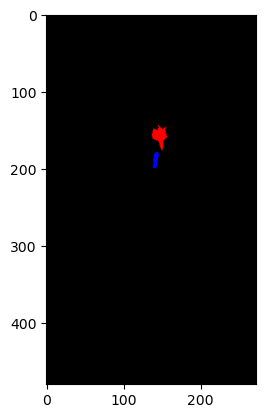

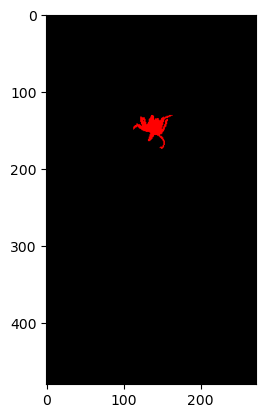

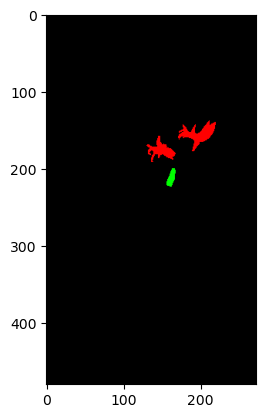

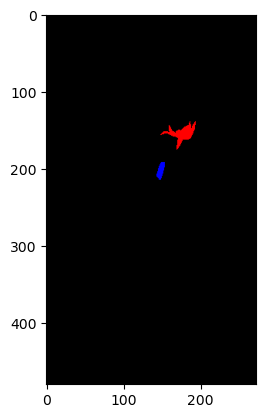

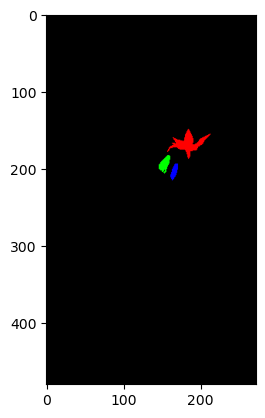

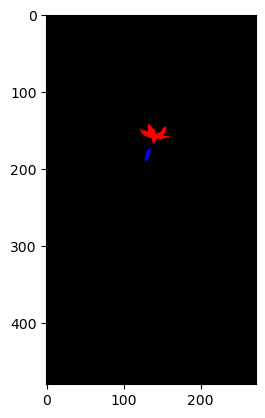

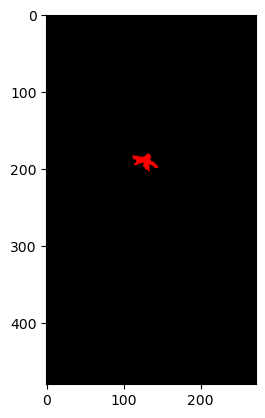

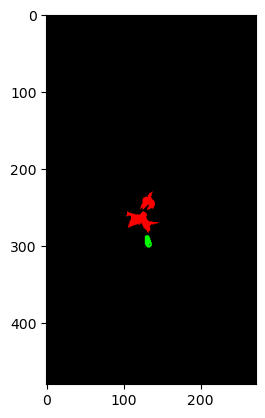

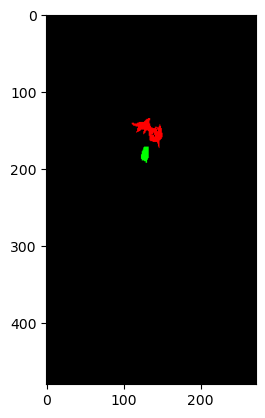

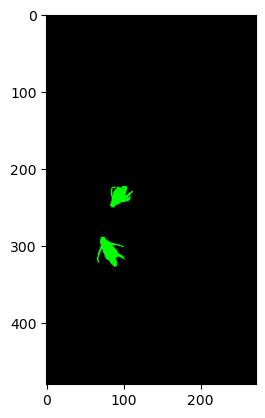

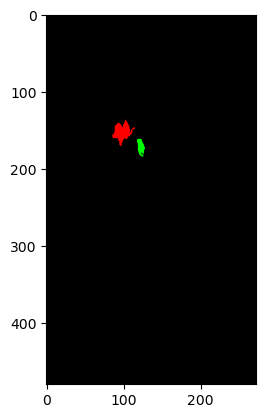

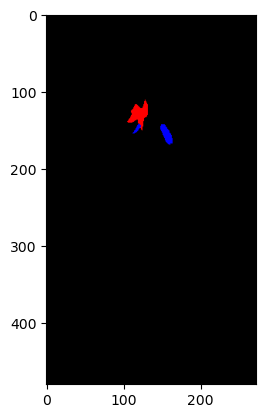

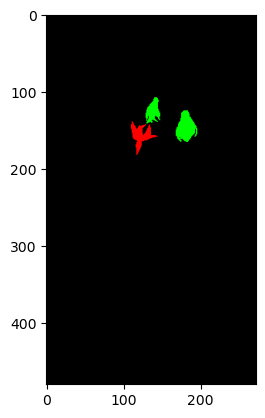

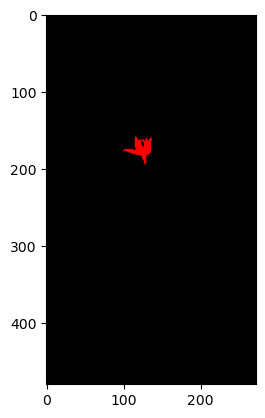

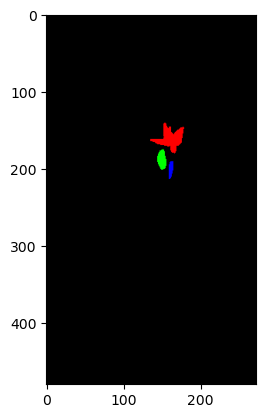

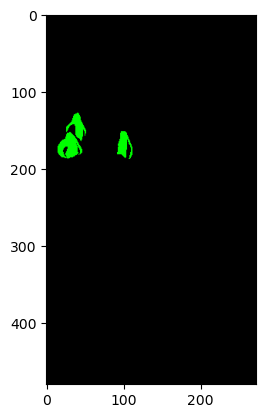

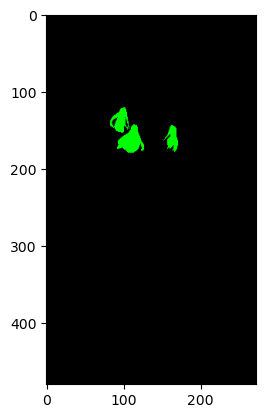

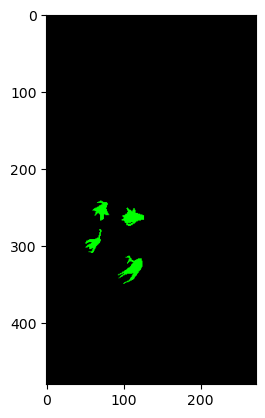

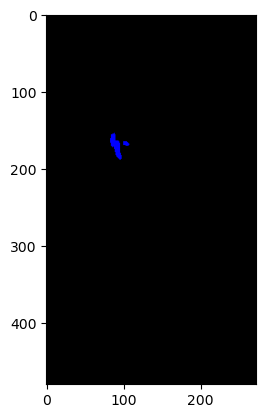

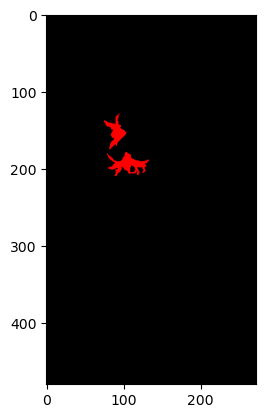

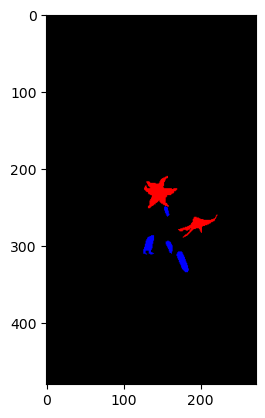

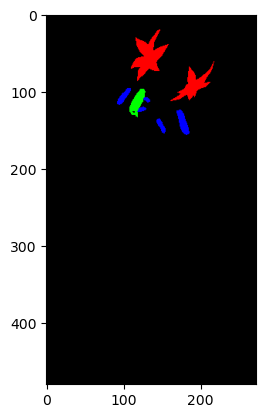

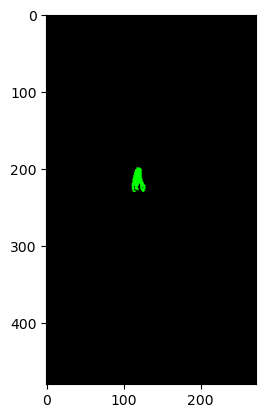

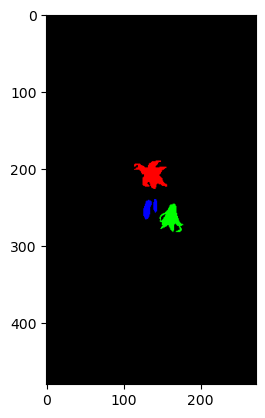

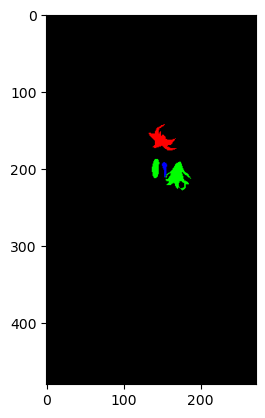

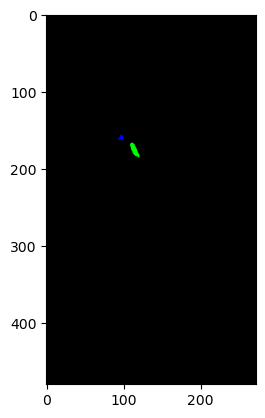

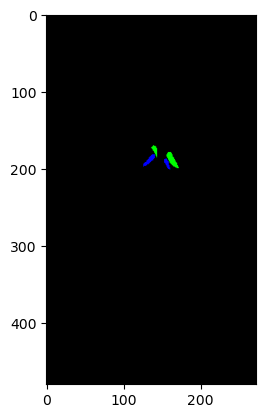

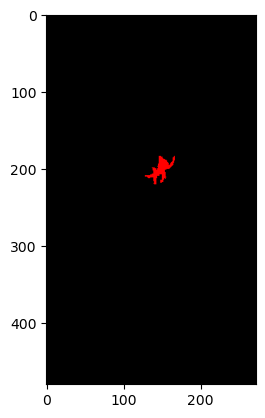

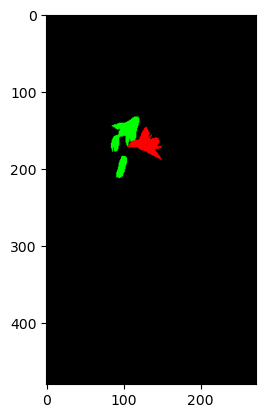

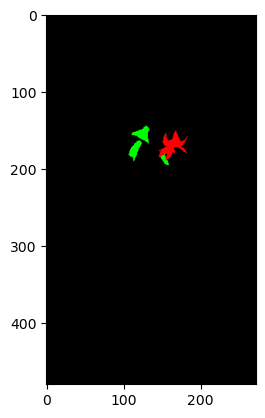

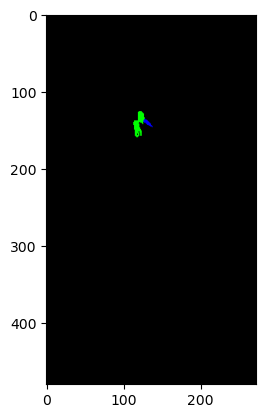

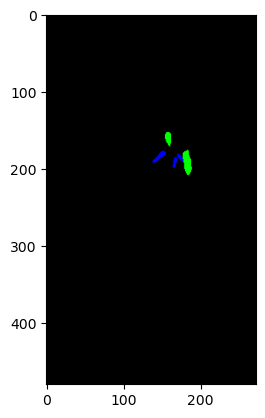

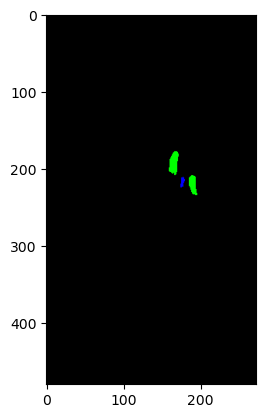

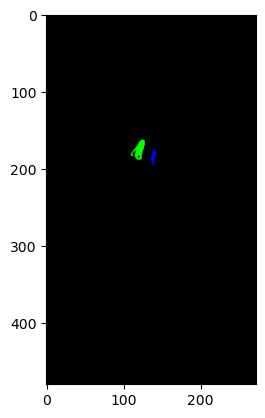

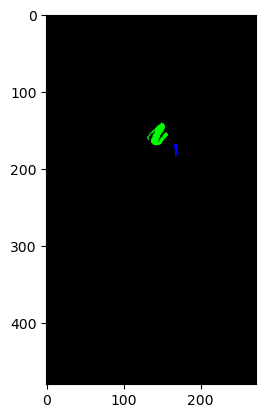

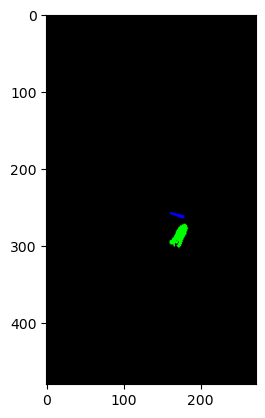

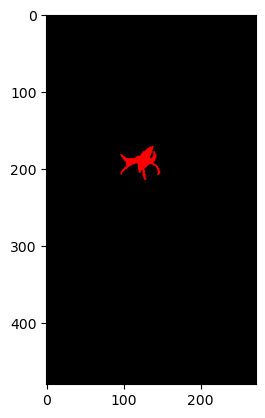

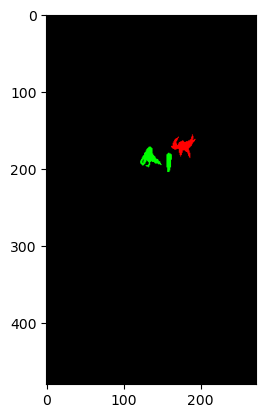

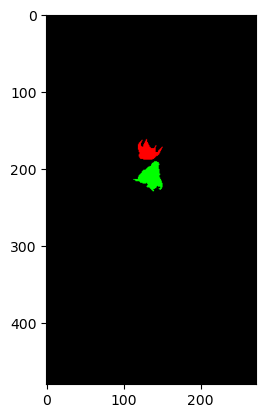

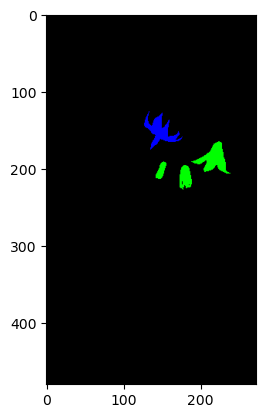

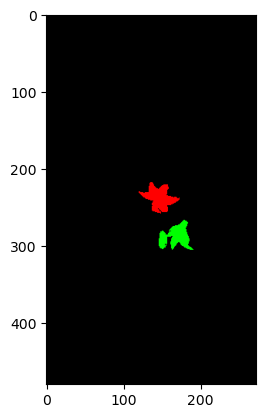

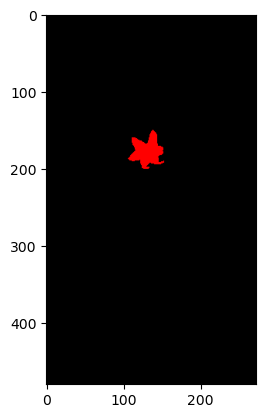

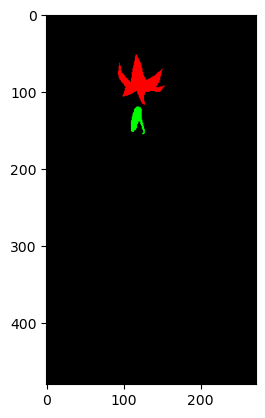

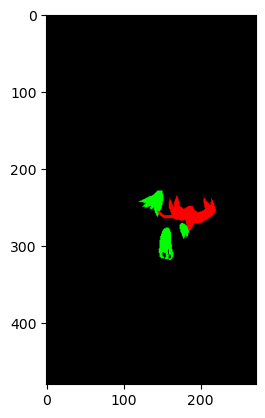

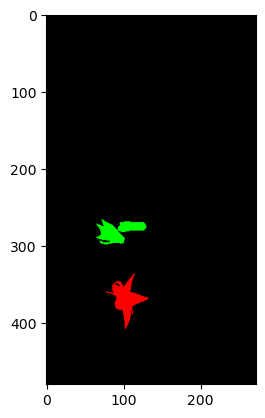

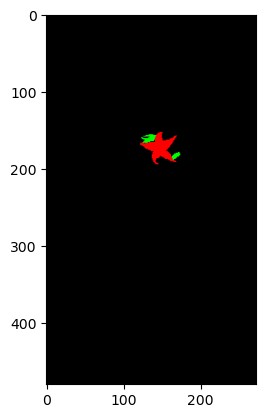

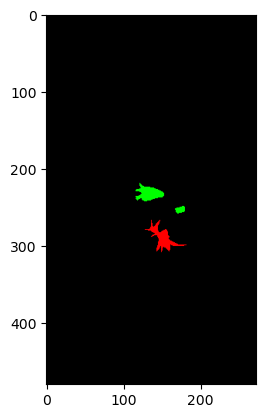

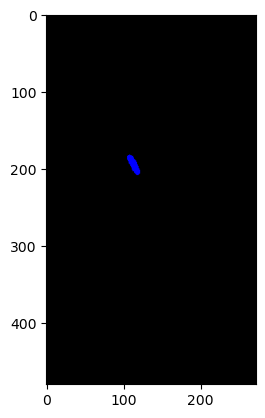

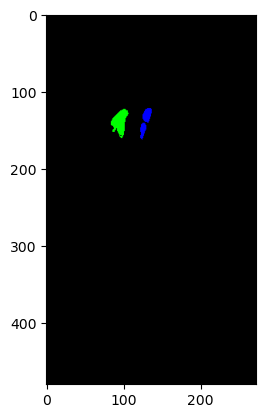

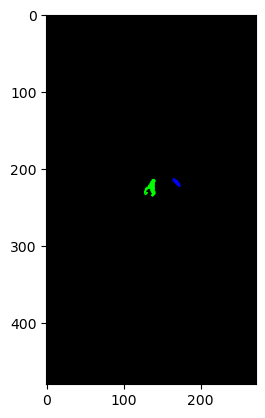

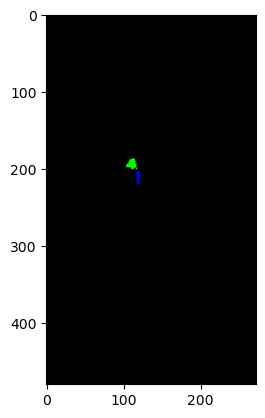

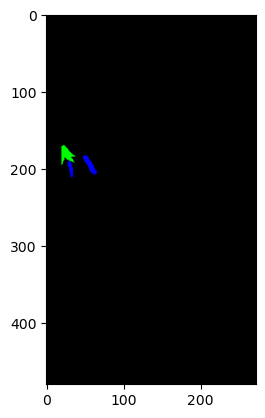

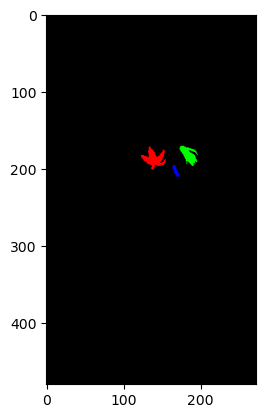

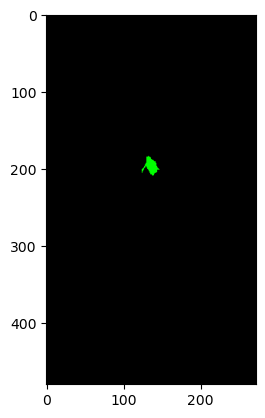

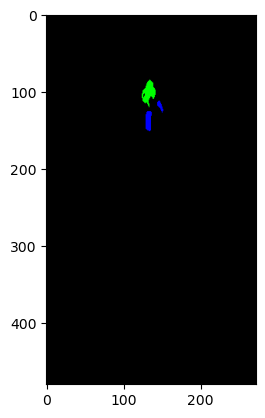

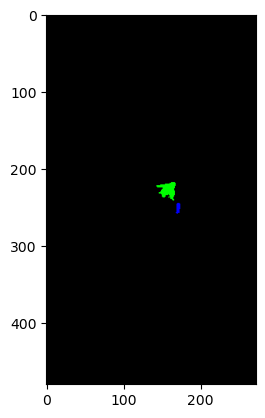

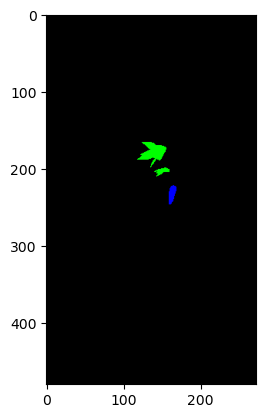

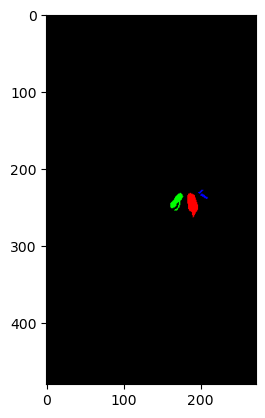

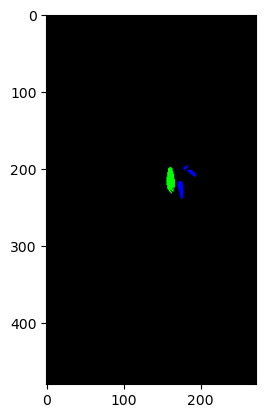

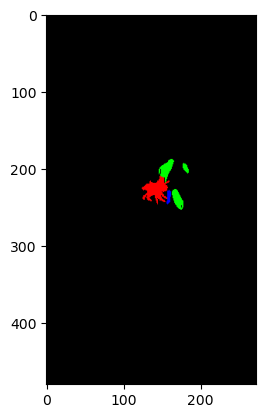

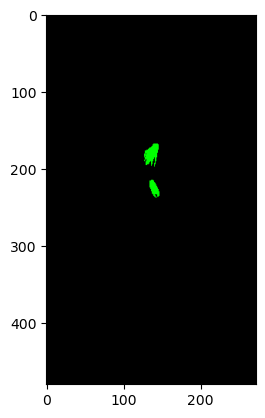

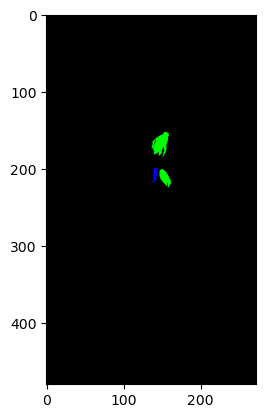

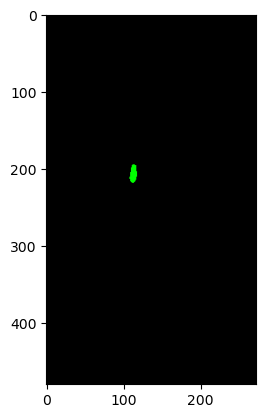

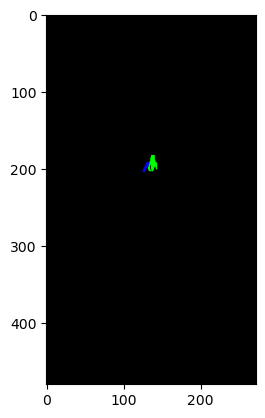

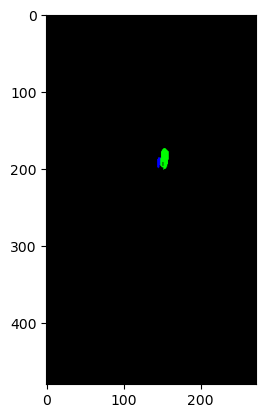

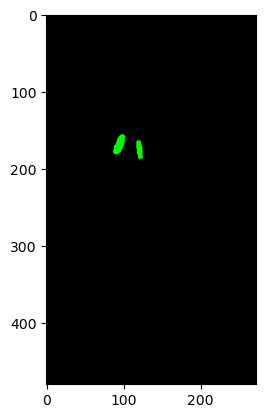

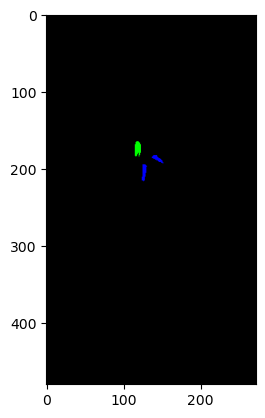

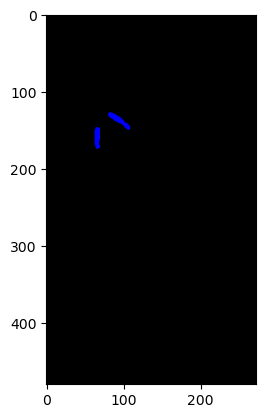

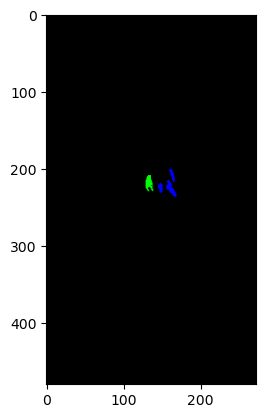

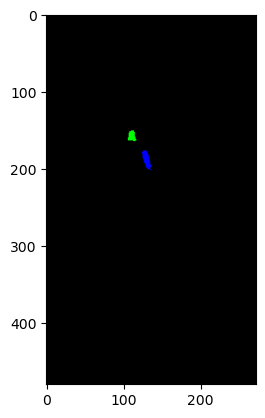

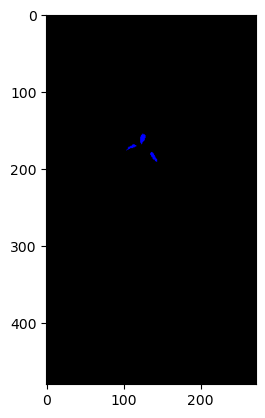

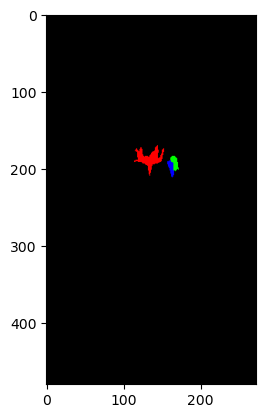

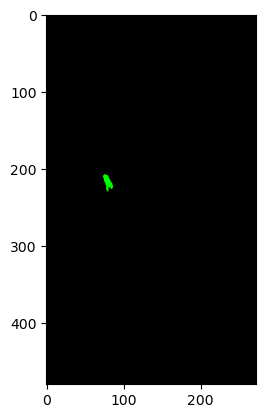

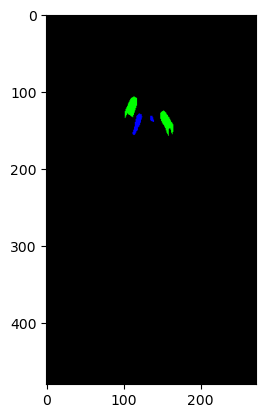

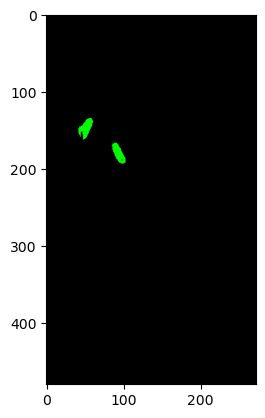

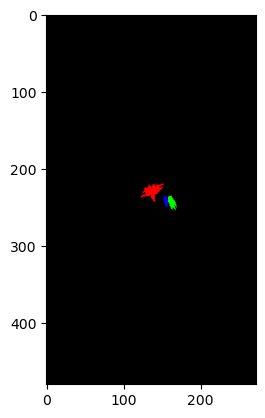

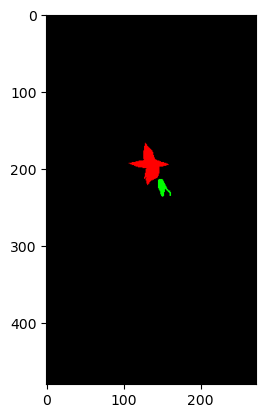

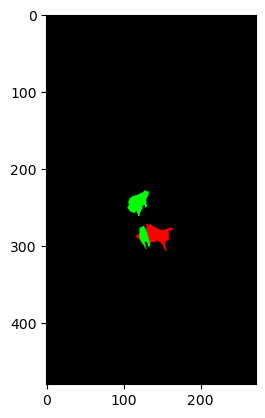

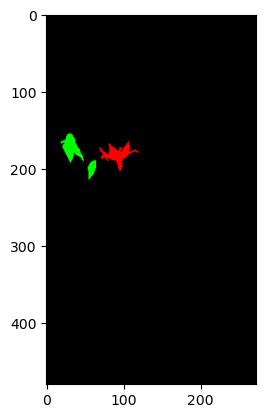

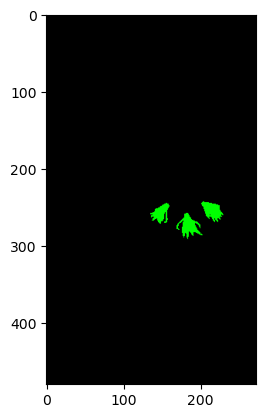

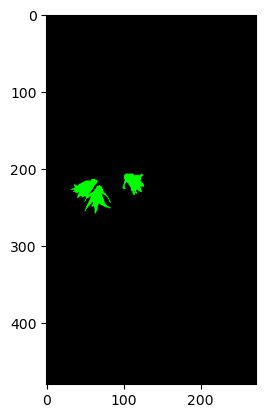

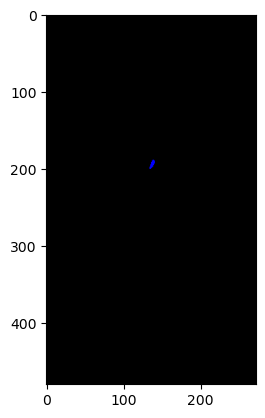

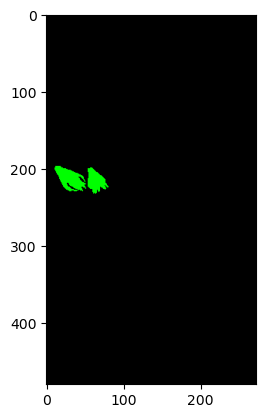

In [16]:
img_directory = 'E:\\Unet\\개화군(꽃)_축소이미지'
json_directory = 'E:\\Unet\\개화군(꽃)_축소JSON'

image_files = [os.path.join(img_directory, file) for file in os.listdir(img_directory) if file.endswith('.png')][:400]
json_files = [os.path.join(json_directory, file.replace('.png', '.json')) for file in os.listdir(img_directory) if file.endswith('.png')][:400]

print(f"Number of image files: {len(image_files)}")
print(f"Number of json files: {len(json_files)}")

for image_file, json_file in zip(image_files, json_files):
    image = Image.open(image_file)
    image = np.array(image)

    if image is None:
        print(f"Cannot load image: {image_file}")
        continue

    with open(json_file, 'r') as f:
        data = json.load(f)

    original_size = (data['imageWidth'], data['imageHeight'])

    # 라벨별 RGB 값 지정
    colors = [(0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255)]

    # 세그멘테이션 이미지 초기화 (모든 픽셀 값이 0인 이미지)
    segmentation = np.zeros((original_size[1], original_size[0], 3), dtype=np.uint8)

    shapes = data['shapes']
    
    # points로 가져온 좌표 안쪽은 라벨에 따라 다른 색상으로 라벨링
    for shape in shapes:
        points = np.array(shape['points'], dtype=np.int32)
        label = shape['label']
        if label == "tom_flower_poly":
            cv2.fillPoly(segmentation, [points], colors[1])
        elif label == "tom_flower_half_poly":
            cv2.fillPoly(segmentation, [points], colors[2])
        elif label == "tom_pre_flowering_poly":
            cv2.fillPoly(segmentation, [points], colors[3])
    
    new_image_path = os.path.join("E:/Unet/개화군(꽃)/", os.path.split(image_file)[1].replace('.png', '_seg.png'))

    img_pil = Image.fromarray(segmentation)
    img_pil.save(new_image_path)

    # 세그멘테이션 이미지를 화면에 출력
    plt.imshow(segmentation)
    plt.show()

In [17]:
def ConvBlock(filters, inputs):
    x = Conv2D(filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [18]:
def create_model(input_shape):
    inputs = Input(input_shape)

    conv1 = ConvBlock(64, inputs)
    drop1 = Dropout(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = ConvBlock(128, pool1)
    drop2 = Dropout(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = ConvBlock(256, pool2)
    drop3 = Dropout(0.2)(conv3)

    # Bridge
    bridge = ConvBlock(512, drop3)

    up4 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(bridge)
    merge4 = concatenate([drop2, up4], axis=3)
    conv4 = ConvBlock(128, merge4)
    drop4 = Dropout(0.2)(conv4)

    up5 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(drop4)
    merge5 = concatenate([drop1, up5], axis=3)
    conv5 = ConvBlock(64, merge5)
    drop5 = Dropout(0.2)(conv5)

    conv6 = Conv2D(4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop5)  # 유닛 수를 4개로 변경
    conv7 = Conv2D(4, 1, activation='softmax')(conv6)  # 활성화 함수를 softmax로 변경

    model = Model(inputs=inputs, outputs=conv7)

    return model

In [19]:
img_directory = 'E:\\Unet\\개화군(꽃)_축소이미지'
segmentation_directory = "E:/Unet/개화군(꽃)/"

image_files = [os.path.join(img_directory, file) for file in os.listdir(img_directory) if file.endswith('.png')]
segmentation_files = [os.path.join(segmentation_directory, file.replace('.png', '_seg.png')) for file in os.listdir(img_directory) if file.endswith('.png')]

# 학습 데이터와 테스트 데이터로 나누는 부분
image_train_files = image_files[200:400]
segmentation_train_files = segmentation_files[200:400]
image_test_files = image_files[400:450]
segmentation_test_files = segmentation_files[400:450]

# 이미지와 세그멘테이션 레이블의 크기를 조정할 크기
target_size = (480, 272)

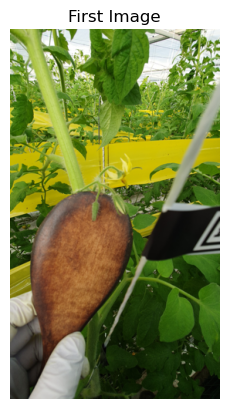

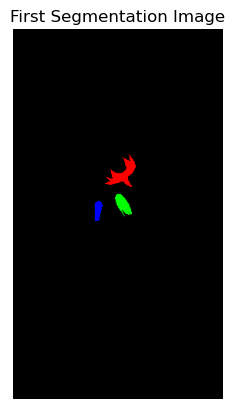

In [20]:
# 첫 번째 이미지 파일 불러오기
image = Image.open(image_files[0])
plt.imshow(image)
plt.title("First Image")
plt.axis('off')  # 축을 표시하지 않습니다.
plt.show()

# 첫 번째 세그멘테이션 이미지 파일 불러오기
segmentation = Image.open(segmentation_files[0])
plt.imshow(segmentation)
plt.title("First Segmentation Image")
plt.axis('off')  # 축을 표시하지 않습니다.
plt.show()

In [21]:
def convert_segmentation(segmentation, colors):
    segmentation_labels = np.zeros(segmentation.shape[:2], dtype=np.uint8)
    for i, color in enumerate(colors):
        segmentation_labels[np.all(segmentation == color, axis=2)] = i
    return segmentation_labels

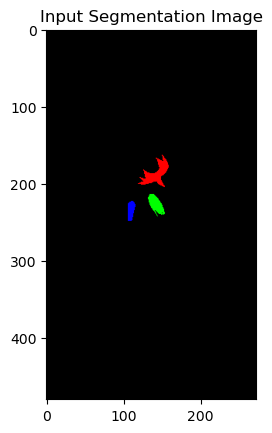

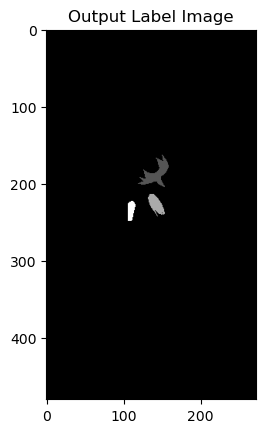

Number of pixels for class 0: 129408
Number of pixels for class 1: 0
Number of pixels for class 2: 0
Number of pixels for class 3: 0


In [22]:
# 테스트를 위한 세그멘테이션 이미지 선택
segmentation_test_file = segmentation_files[0]

# 세그멘테이션 이미지 로드
segmentation = load_img(segmentation_test_file, target_size=target_size)
segmentation = img_to_array(segmentation)

# convert_segmentation 함수 호출
segmentation_labels = convert_segmentation(segmentation, colors)

# 입력 세그멘테이션 이미지 출력
plt.imshow(segmentation/255.0)  # 픽셀 값을 0과 1 사이로 정규화하여 출력
plt.title("Input Segmentation Image")
plt.show()

# 출력 라벨 이미지 출력
plt.imshow(segmentation_labels, cmap='gray')
plt.title("Output Label Image")
plt.show()

# 각 클래스의 픽셀 수 출력
for i in range(len(colors)):
    print(f"Number of pixels for class {i}: {np.sum(segmentation_labels == i/255.0)}")


In [23]:
def load_data(image_files, segmentation_files, target_size, num_classes):
    images = []
    labels = []

    
    colors = [(0, 0, 0),(255, 0, 0), (0, 255, 0), (0, 0, 255)]

    for image_file, segmentation_file in zip(image_files, segmentation_files):
        # 이미지 로드
        image = load_img(image_file, target_size=target_size)
        image = img_to_array(image)

        # 세그멘테이션 이미지 로드
        segmentation = load_img(segmentation_file, target_size=target_size)
        segmentation = img_to_array(segmentation)

        # 세그멘테이션 이미지 변환
        segmentation = convert_segmentation(segmentation, colors)

        # 원-핫 인코딩
        segmentation = to_categorical(segmentation, num_classes)

        images.append(image)
        labels.append(segmentation)

    # numpy array로 변환
    images = np.array(images)
    labels = np.array(labels)

    return images, labels


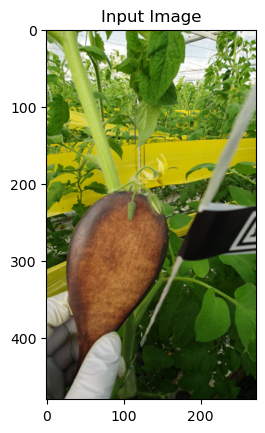

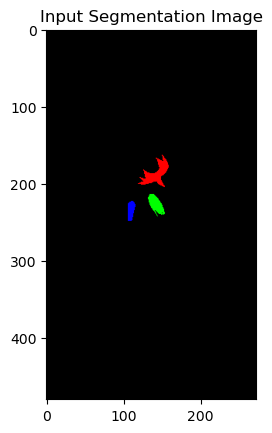

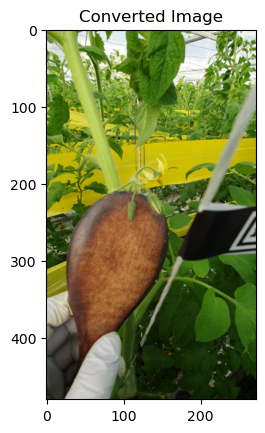

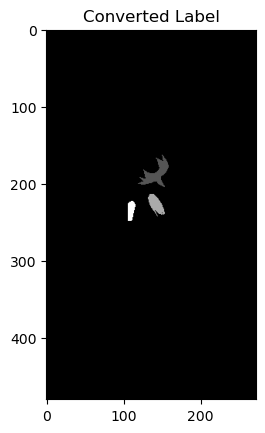

Images shape: (1, 480, 272, 3)
Labels shape: (1, 480, 272, 4)


In [24]:
# 테스트를 위한 이미지 파일과 세그멘테이션 파일 선택
image_test_file = image_files[0]
segmentation_test_file = segmentation_files[0]

# load_data 함수 호출
images, labels = load_data([image_test_file], [segmentation_test_file], target_size, num_classes=4)

# 입력 이미지와 세그멘테이션 이미지 출력
image = load_img(image_test_file, target_size=target_size)
plt.imshow(image)
plt.title("Input Image")
plt.show()

segmentation = load_img(segmentation_test_file, target_size=target_size)
plt.imshow(segmentation)
plt.title("Input Segmentation Image")
plt.show()

# 변환된 이미지와 라벨 출력
plt.imshow(images[0].astype(int))  # float 타입을 int로 변환하여 출력
plt.title("Converted Image")
plt.show()

plt.imshow(np.argmax(labels[0], axis=-1), cmap='gray')  # 원-핫 인코딩된 라벨을 클래스 라벨로 변환하여 출력
plt.title("Converted Label")
plt.show()

# 출력의 shape 출력
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


In [25]:
# 학습 데이터 로드
x_train, y_train = load_data(image_train_files, segmentation_train_files, target_size, num_classes=4)

# 학습 데이터를 평가하는 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 테스트 데이터 로드
x_test, y_test = load_data(image_test_files, segmentation_test_files, target_size, num_classes=4)

y_train shape: (160, 480, 272, 4)


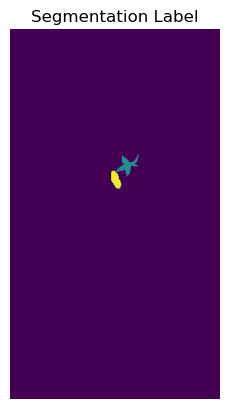

In [26]:
# y_train 중 첫 번째 이미지를 시각화합니다.
# 원하는 인덱스를 선택하여 다른 이미지를 볼 수도 있습니다.
index_to_show = 3

# y_train의 shape을 확인하여 적절한 인덱스를 선택하세요.
print("y_train shape:", y_train.shape)

if len(y_train.shape) == 4:
    # 마지막 차원이 클래스를 나타내므로, 가장 큰 값의 인덱스를 통해 가장 가능성 높은 클래스를 선택합니다.
    # 이는 one-hot 인코딩된 레이블에 해당됩니다.
    y_train_argmax = np.argmax(y_train[index_to_show], axis=-1)
    
    plt.imshow(y_train_argmax, cmap='viridis')  # gray colormap을 사용해 레이블을 표시합니다.
    plt.title("Segmentation Label")
    plt.axis('off')  # 축을 표시하지 않습니다.
    plt.show()
else:
    print("y_train의 차원이 예상과 다릅니다. 이미지를 시각화하기 위한 차원이 맞는지 확인해주세요.")

In [27]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (160, 480, 272, 3)
y_train shape: (160, 480, 272, 4)


In [14]:
# 모델 생성
input_shape = (480, 272, 3)  # 실제 이미지의 크기
model = create_model(input_shape=input_shape)  # 실제 이미지 크기에 맞게 모델 생성

# 모델 컴파일
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])  # 손실 함수를 categorical_crossentropy로 변경

# 모델 학습
history = model.fit(x_train, y_train, batch_size=4, epochs=200, validation_data=(x_val, y_val))

# 모델 저장
model.save('unet_model_truss.h5')

Epoch 1/200
40/40 [==============================] - 35s 707ms/step - loss: 0.6329 - accuracy: 0.9678 - val_loss: 0.2679 - val_accuracy: 0.9927
Epoch 2/200
40/40 [==============================] - 28s 699ms/step - loss: 0.1367 - accuracy: 0.9934 - val_loss: 0.1360 - val_accuracy: 0.9927
Epoch 3/200
40/40 [==============================] - 28s 702ms/step - loss: 0.0351 - accuracy: 0.9934 - val_loss: 0.1460 - val_accuracy: 0.9927
Epoch 4/200
40/40 [==============================] - 28s 708ms/step - loss: 0.0270 - accuracy: 0.9934 - val_loss: 0.1742 - val_accuracy: 0.9927
Epoch 5/200
40/40 [==============================] - 28s 705ms/step - loss: 0.0250 - accuracy: 0.9934 - val_loss: 0.0711 - val_accuracy: 0.9927
Epoch 6/200
40/40 [==============================] - 28s 704ms/step - loss: 0.0230 - accuracy: 0.9934 - val_loss: 0.0396 - val_accuracy: 0.9927
Epoch 7/200
40/40 [==============================] - 28s 705ms/step - loss: 0.0218 - accuracy: 0.9934 - val_loss: 0.0524 - val_accuracy:

In [30]:
from tensorflow.keras.models import load_model

# 모델 파일의 이름을 'my_model.h5'라고 가정했을 때,
model = load_model('unet_model_truss.h5')

In [31]:
# 모델 평가
loss, acc = model.evaluate(x_test, y_test, batch_size=4)
print(f"Test Loss: {loss}, Test Accuracy: {acc}")

# 모델 예측
predictions = []
batch_size = 4  # 배치 크기를 조절하실 수 있습니다.
for i in range(0, len(x_test), batch_size):
    batch = x_test[i:i+batch_size]
    batch_predictions = model.predict(batch)
    predictions.extend(batch_predictions)

13/13 [==============================] - 10s 312ms/step - loss: 0.0261 - accuracy: 0.9970
Test Loss: 0.026084255427122116, Test Accuracy: 0.9969627857208252
1/1 [==============================] - 0s 23ms/step


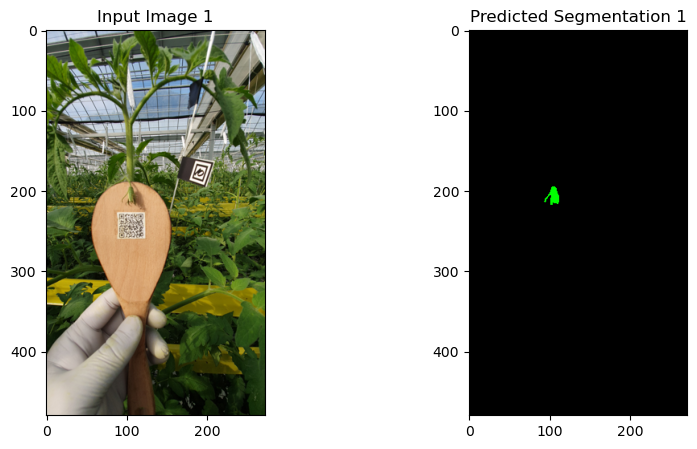

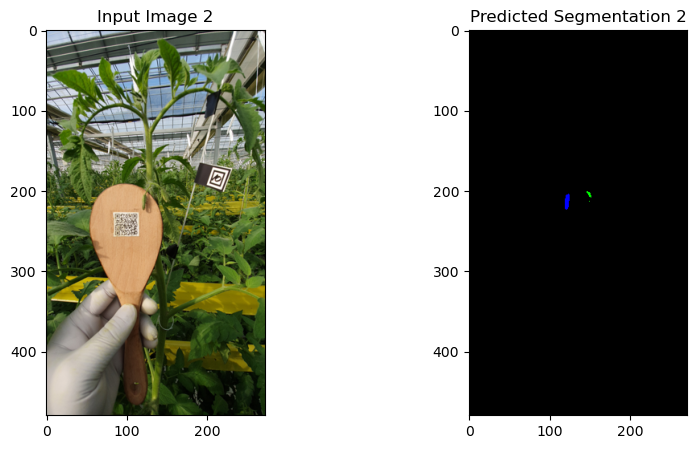

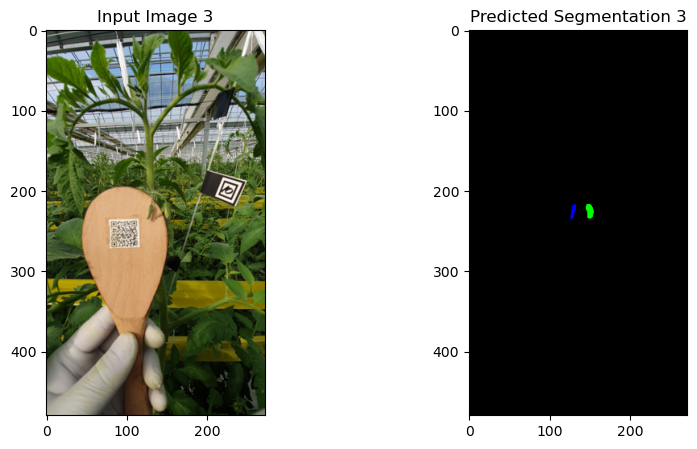

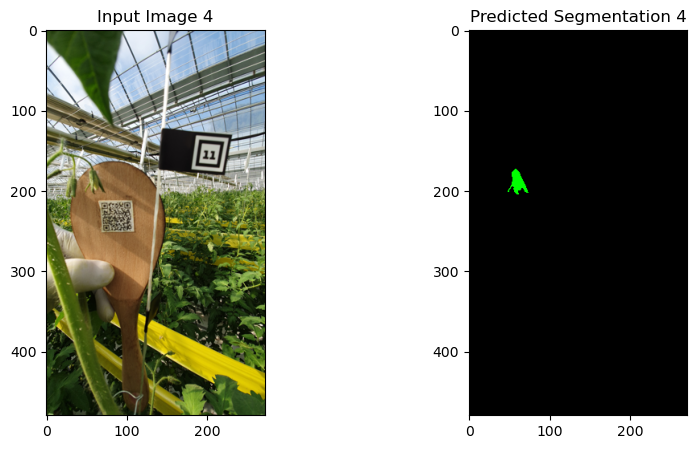

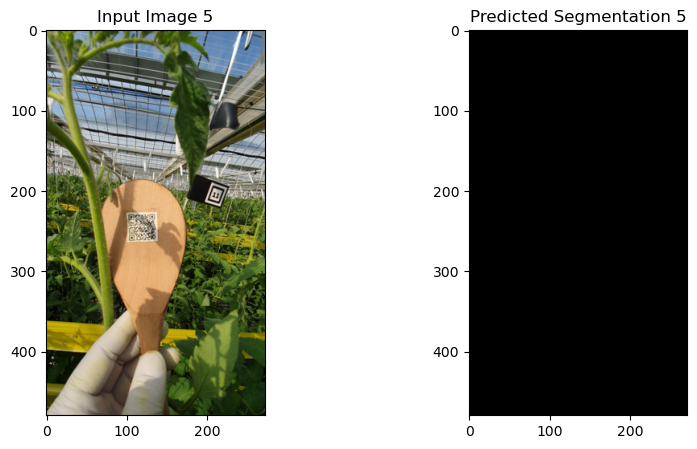

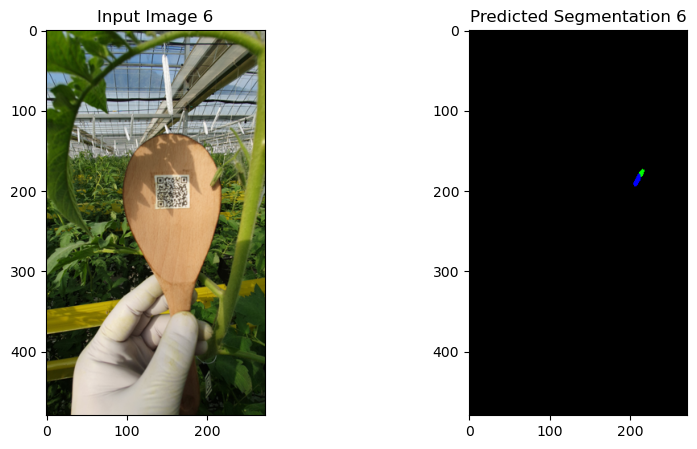

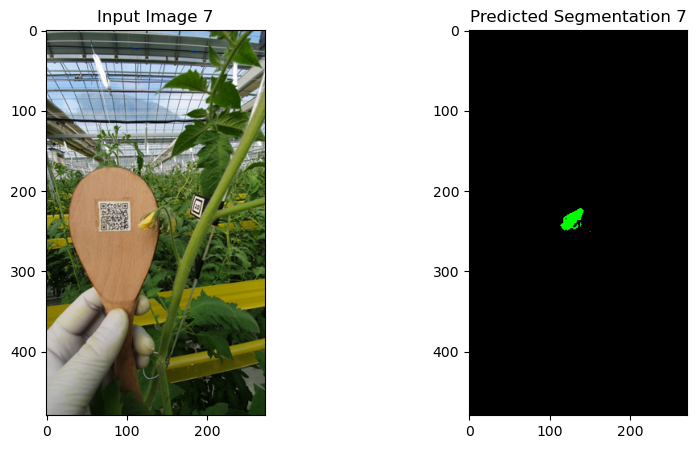

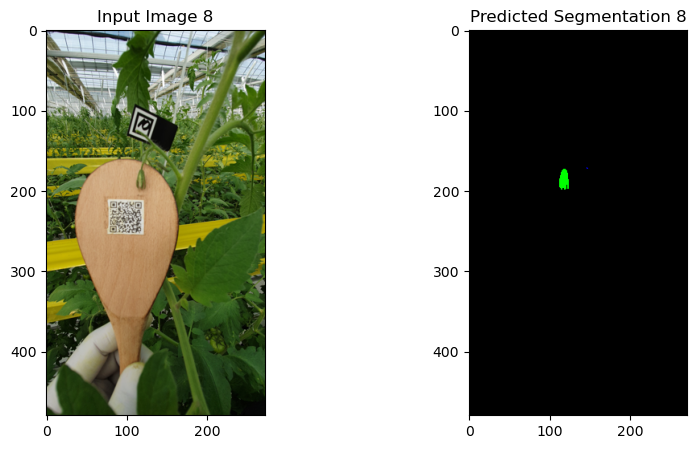

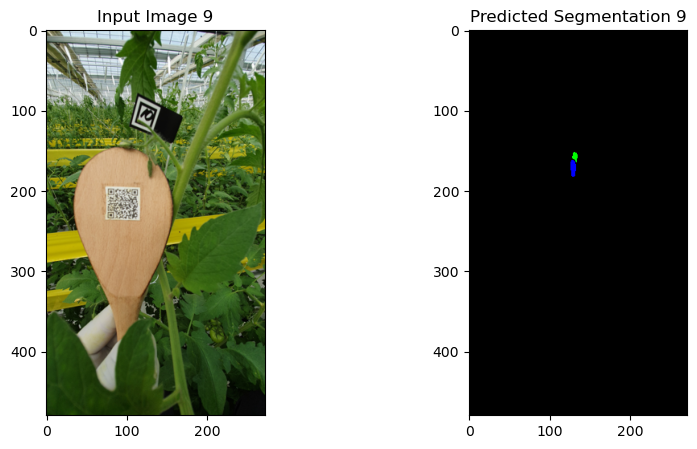

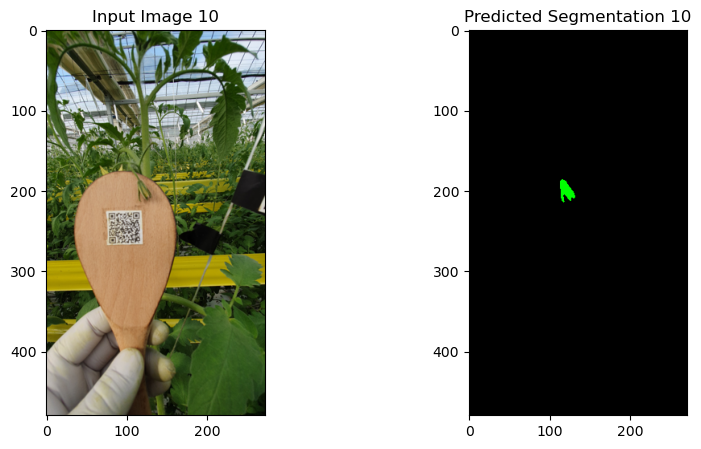

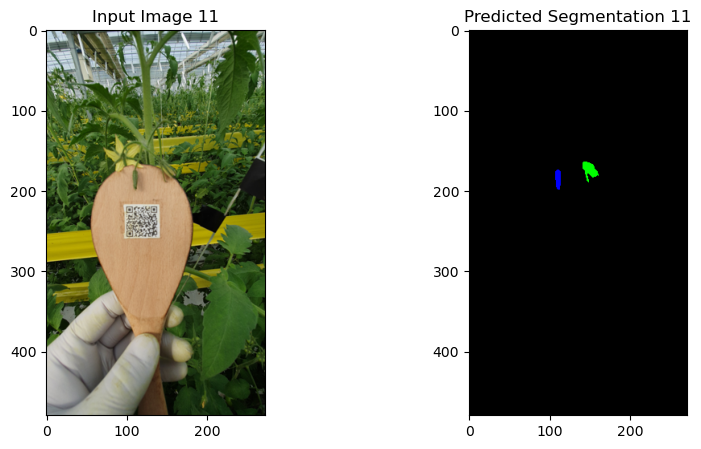

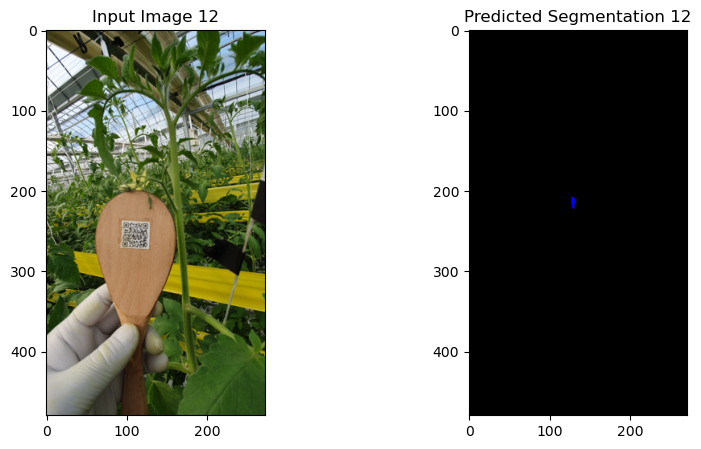

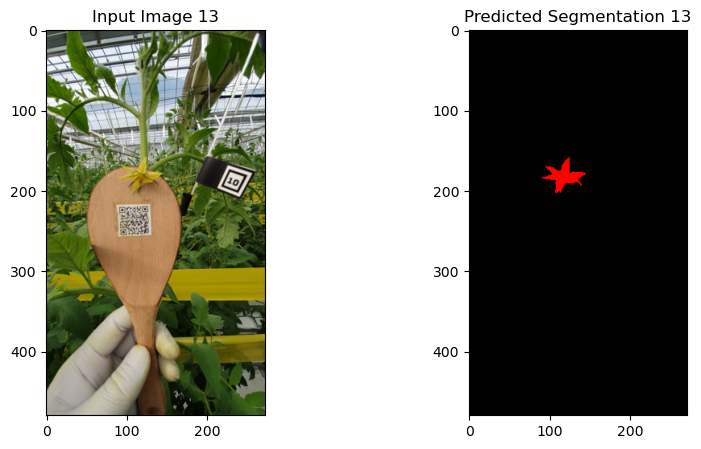

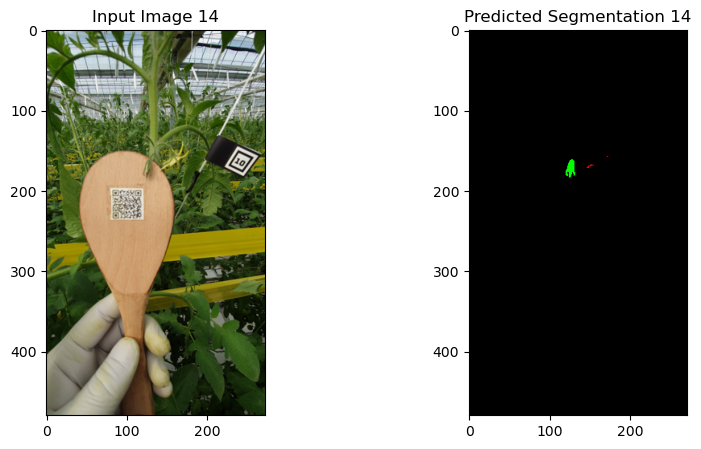

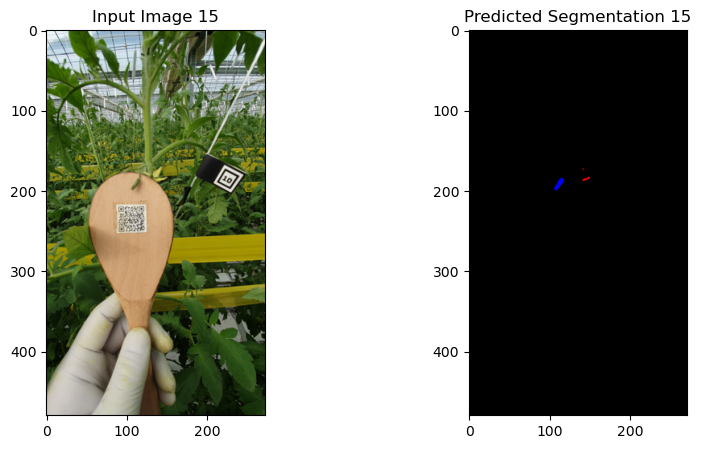

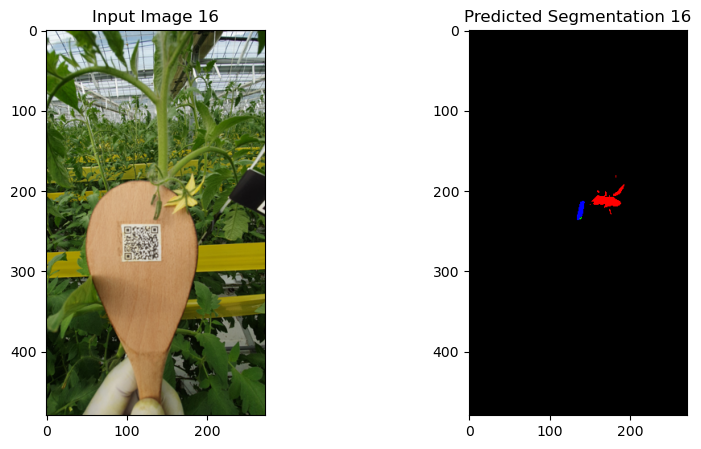

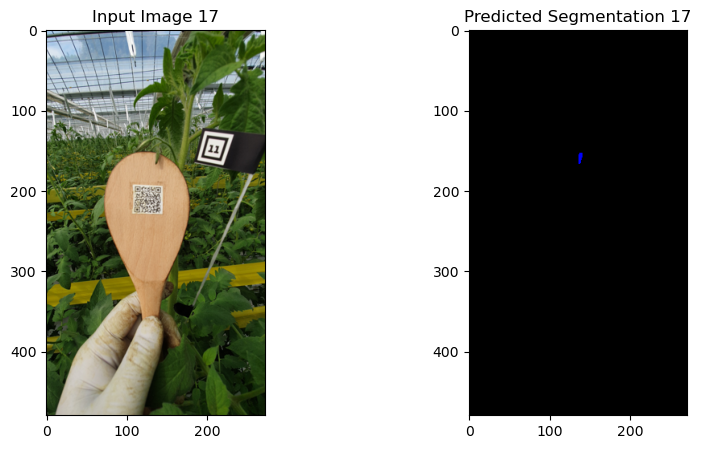

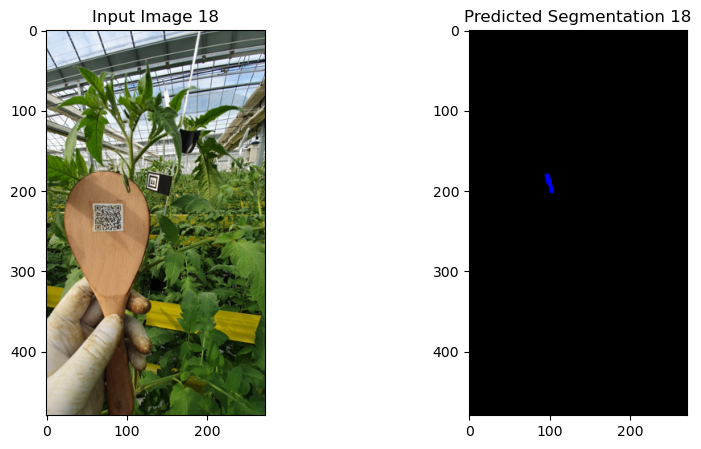

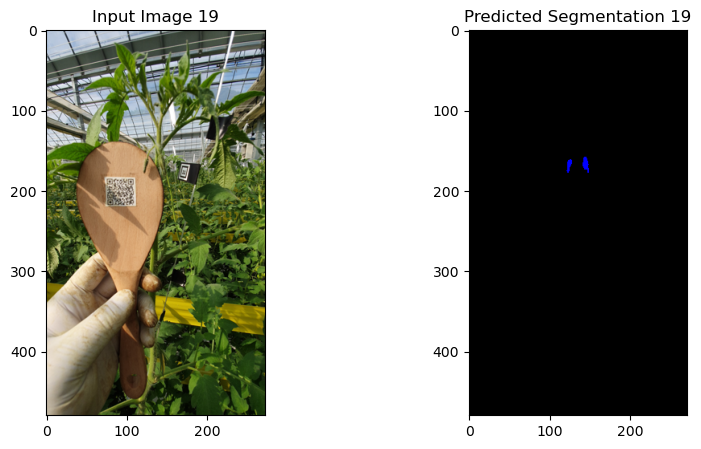

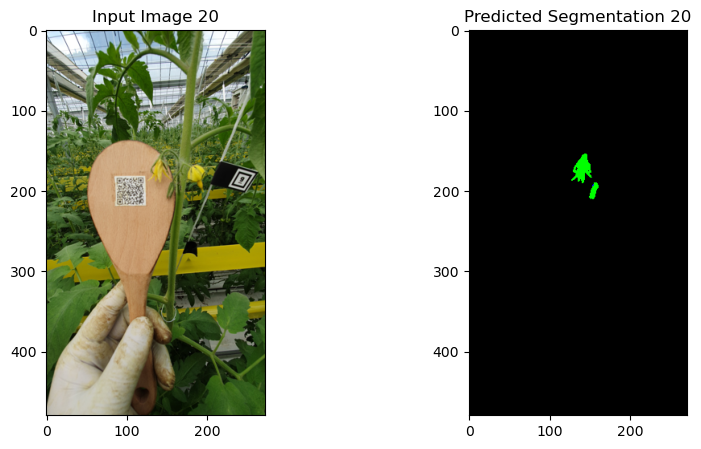

In [109]:
def decode_predictions(predictions, colors):
    # 원-핫 인코딩된 예측 결과를 원래의 라벨로 변환
    labels = np.argmax(predictions, axis=-1)

    # 각 라벨에 색상 부여
    colored_labels = np.zeros((labels.shape[0], labels.shape[1], labels.shape[2], 3))
    for i, color in enumerate(colors):
        colored_labels[labels == i] = color

    return colored_labels

# 예측 결과 디코딩
colored_predictions = decode_predictions(predictions, colors)

# 예측 결과 시각화
for i in range(20):  # 5개의 이미지 쌍을 출력
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 원본 이미지와 예측 결과를 나란히 출력
    ax[0].imshow(x_test[i] / 255.0)  # 원본 이미지
    ax[0].set_title(f"Input Image {i+1}")
    ax[1].imshow(colored_predictions[i].astype(np.uint8))  # 디코딩된 예측 결과
    ax[1].set_title(f"Predicted Segmentation {i+1}")
    plt.show()


In [17]:
# 결과를 확인하기 위해 작성한 코드
print(predictions[2])

[[[9.9998343e-01 1.2654838e-05 8.2992365e-08 3.8485919e-06]
  [1.0000000e+00 6.5748287e-09 7.8594431e-12 4.3314548e-09]
  [1.0000000e+00 3.9129547e-10 1.1797532e-13 1.7070226e-10]
  ...
  [1.0000000e+00 2.5722660e-09 1.5361018e-13 1.1767458e-10]
  [1.0000000e+00 2.3648152e-09 1.8279695e-13 1.3852844e-10]
  [9.9999928e-01 4.7898328e-07 1.6402937e-09 2.0202607e-07]]

 [[1.0000000e+00 3.4023490e-08 2.0743993e-11 7.0789250e-09]
  [1.0000000e+00 3.5264416e-13 7.4803425e-17 1.0024937e-12]
  [1.0000000e+00 6.4006743e-15 2.6160161e-19 1.3578610e-14]
  ...
  [1.0000000e+00 2.6000859e-13 1.3443463e-19 2.7818099e-15]
  [1.0000000e+00 1.3825925e-13 5.0421544e-20 1.2979672e-15]
  [1.0000000e+00 1.0244440e-09 1.9605228e-13 1.7626375e-10]]

 [[1.0000000e+00 1.7530893e-09 7.0500120e-12 5.5006781e-09]
  [1.0000000e+00 1.8352771e-14 1.7024059e-17 5.3217267e-13]
  [1.0000000e+00 6.5236275e-16 1.2181535e-19 1.1907870e-14]
  ...
  [1.0000000e+00 1.3734466e-12 2.6696398e-18 2.0210316e-14]
  [1.0000000e+00 4

In [66]:
from tensorflow.keras.metrics import MeanIoU

num_classes = 4  # 클래스의 수를 설정해주세요. 이 값은 데이터셋에 따라 다릅니다.
iou_calculator = MeanIoU(num_classes)

# 예측값을 생성합니다. model은 이미 학습된 U-Net 모델이어야 합니다.
predictions = model.predict(x_test, batch_size=4)

# 예측값을 이진화합니다.
predictions = (predictions > 0.5).astype('int')

# IoU를 계산합니다.
iou_calculator.update_state(y_test, predictions)
print("IoU: ", iou_calculator.result().numpy())

13/13 [==============================] - 3s 247ms/step
IoU:  0.99580115
